In [1]:
import numpy as np
from scipy.stats import gaussian_kde
import theano.tensor as T
import theano
import os
import re
import glob
import h5py
from keras.layers.advanced_activations import PReLU, LeakyReLU
from scipy.stats import norm
from keras import *
from sklearn.metrics import roc_curve, roc_auc_score, auc
from keras.models import Sequential,Model
from keras.layers import Dense, Activation,Input, Dense, Dropout, merge, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization
from keras.optimizers import *
from keras.models import model_from_json, save_model
from keras.layers import *
import matplotlib.pyplot as plt
%matplotlib inline
from keras import backend as K
from keras.engine import InputSpec, Layer
from keras import initializers, regularizers, constraints

Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
/tmp/try_flags_s4hGkr.c:4:19: fatal error: cudnn.h: No such file or directory
compilation terminated.

Mapped name None to device cuda0: GeForce GTX 860M (0000:01:00.0)
Using Theano backend.


In [2]:
def loadmodel(name, weights = False):
    json_file = open('%s_m.json'%name, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    #load weights into new model
    if weights==True:
        model.load_weights('%s_w.h5'%name)
    print (model.summary())
    print("Loaded model %s from disk"%name)
    return model

def savemodel(model,name="neural network"):
    #print "Saving model:"
    model_name = name
    #model.summary()
    model.save_weights('%s_w.h5'%model_name, overwrite=True)
    model_json = model.to_json()
    with open("%s_m.json"%model_name, "w") as json_file:
        json_file.write(model_json)
        
def savelosses(hist, name="neural network"):  
    print "Saving losses:"
    loss = np.array(hist.history['loss'])
    valoss = np.array(hist.history['val_loss'])
    f = h5py.File("%s_h.h5"%name,"w")
    f.create_dataset('loss',data=loss)
    f.create_dataset('val_loss',data=valoss)
    f.close()

In [3]:
def hist(y, n=25):
    plt.figure(figsize=(8,8))
    l = y.min()
    r = y.max()
    w = ((r-l)/float(y.shape[0]*1.))
    plt.hist(y, histtype='step', bins=n)
    plt.show()

#generates a Gaussian 
def gaussian(batch_size, mu=0.,sigma=0.5):
    sample = np.random.normal(mu, sigma, batch_size)
    sample.sort()
    return np.reshape(sample,(len(sample),1))

def noise(batch_size, m=-2.5, M=2.5):
    a = np.linspace(m, M, batch_size) + np.random.random(batch_size) * 0.01
    return np.reshape(a,(len(a),1))

def noise_g(batch_size, mu=0.,sigma=0.6):
    #gaussian noise sample with perturbations
    sample = np.random.normal(mu, sigma, batch_size)+np.random.random(batch_size) * 0.01
    sample.sort()
    return np.reshape(sample,(len(sample),1))

#y=gaussian(batch_size=10000, mu=5, sigma=5)
#print y.shape
#hist(y)

In [4]:
def plot_loss(losses,modelname="GAN"):
    #display.clear_output(wait=True)
    #display.display(plt.gcf())
    plt.figure(figsize=(16,9))
    plt.plot(losses["d_f"], label='discriminative loss on fake', alpha=0.8)
    plt.plot(losses["d_t"], label='discriminative loss on true', alpha=0.8)
    plt.plot(losses["d"], label = 'discriminative loss', alpha=0.8)
    plt.plot(losses["g"], label='generative loss', alpha=0.8)
    #plt.yscale('log')
    plt.xlabel('Epochs', fontsize=22)
    plt.ylabel('Loss', fontsize=22)
    plt.legend(fontsize=22, loc='best', fancybox=True, framealpha=0.)
    plt.savefig("%s_loss.png"%modelname)
    plt.show()
    
def plot_decision_boundary(disc):
    plt.figure(figsize=(16,9))
    xs = np.linspace(-2.5, 2.5, 10000)
    plt.plot(xs, norm.pdf(xs, loc=0, scale=0.5), label='p_data')
    r = 10000
    xs = np.float32(np.linspace(-2.5, 2.5, r))
    ds_tensor = disc.predict(xs)
    plt.plot(xs, ds_tensor, label='decision boundary')
    plt.legend(fontsize=22, loc='best', fancybox=True, framealpha=0.)
    plt.show()

In [7]:
opt = Adam(lr=1e-4)#, decay = 0.009)
dopt = Adam(lr=1e-3)#, decay = 0.0009)
from keras.models import Sequential,Model

def gen_f():
    
    g_input= Input(shape=[1])
    g = Dense(400)(g_input)
    g = LeakyReLU()(g)
    #g = BatchNormalization()(g)
    g = Dense(1, activation='linear')(g)
    G = Model(g_input,g)
    G.compile(loss='binary_crossentropy', optimizer=opt)
    return G

In [8]:
#From CaloGAN paper (Luke de Oliveira, Michela Paganini and Ben Nachman)
from ops_CaloGAN import *
def minibatch_discriminator(x):
    """ Computes minibatch discrimination features from input tensor x"""
    diffs = K.expand_dims(x, 3) - K.expand_dims(K.permute_dimensions(x, [1, 2, 0]), 0)
    l1_norm = K.sum(K.abs(diffs), axis=2)
    return K.sum(K.exp(-l1_norm), axis=2)


def minibatch_output_shape(input_shape):
    """ Computes output shape for a minibatch discrimination layer"""
    shape = list(input_shape)
    assert len(shape) == 3  # only valid for 3D tensors
    return tuple(shape[:2])




def build_discriminator(d_input, mbd=False):
    """ Generator sub-component for the CaloGAN ---- reusing this recipe for now (KD)

    Args:
    -----
        mdb: bool, perform feature level minibatch discrimination
        
    Returns:
    --------
        a keras tensor of features

    """
    
    d = Dense(400)(d_input)
    d = Activation('tanh')(d)
    d = BatchNormalization()(d)
    d = Dense(400)(d)
    d = Activation('tanh')(d)
    #d = Dense(400)(d)
    #d = Activation('tanh')(d)
    #d = Flatten()(d)
    

    if mbd:
        minibatch_featurizer = Lambda(minibatch_discriminator,
                                      output_shape=minibatch_output_shape)

        features = [d]
        nb_features = 6
        vspace_dim = 2

        # creates the kernel space for the minibatch discrimination
        K_d = Dense3D(nb_features, vspace_dim)(d)
        features.append(Activation('tanh')(minibatch_featurizer(K_d)))
        features = concatenate(features)
        #p = concatenate([features])
        D = Dense(1, kernel_initializer='normal', activation='sigmoid')(features)
        discriminator = Model(d_input,D)
        discriminator.compile(loss='binary_crossentropy', optimizer=dopt)
        return discriminator
    
    else:
        d = Dense(400)(d)
        d = Activation('tanh')(d)
        d = Dense(1, kernel_initializer='normal', activation='sigmoid')(d)
        discriminator = Model(d_input, d)
        discriminator.compile(loss='binary_crossentropy', optimizer=dopt)
        return discriminator

In [9]:
from keras.models import Sequential,Model
from keras.layers import add, concatenate, multiply
mbd=True
def GAN_f(generator, discriminator):

    noise=Input(shape=[1])
    g=generator(noise)
    d=discriminator(g)
    discriminator.trainable = False
    GAN = Model(noise, d)
    GAN.compile(loss='binary_crossentropy', optimizer=opt)
    #GAN.summary()
    return GAN


D = build_discriminator(d_input=Input(shape=[1]), mbd=True)
D.summary()
G = gen_f()
G.summary()
Model = GAN_f(G, D)
D.trainable = True
Model.summary()
#p_g = G.predict(noise(10000))
#plt.hist(p_g)
#plt.show()
#p_d = D.predict(np.ones(5000))
#p_d = np.concatenate((p_d, D.predict(np.zeros(5000))))
#plt.hist(p_d)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 400)           800         input_1[0][0]                    
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 400)           0           dense_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 400)           1600        activation_1[0][0]               
___________________________________________________________________________________________

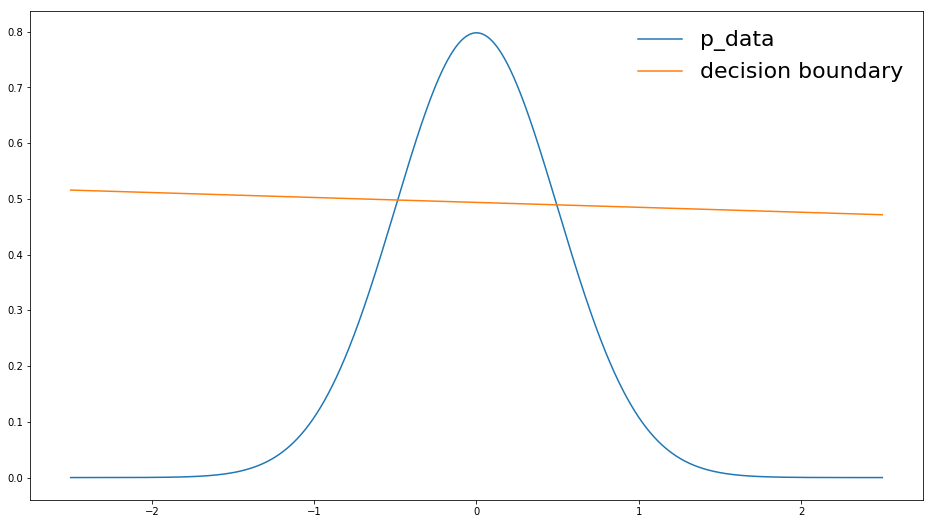

In [10]:
import random
losses = {"d_f":[], "d_t":[], "d":[], "g":[]}
def train(G, D, M, epoch):
    
    true_disc_x = gaussian(batch_size,mu=0.,sigma=0.5)
    sd = np.std(true_disc_x)
    mean = np.mean(true_disc_x)
    latent = noise_g(batch_size, mu=0., sigma = 2.)  # m=true_disc_x.min(), M=true_disc_x.max())
    true_disc_y = np.zeros(batch_size)
    fake_disc_x = G.predict(latent)
    fake_disc_y = np.ones(batch_size)
    
    x_disc = np.concatenate((true_disc_x, fake_disc_x))
    x_disc = x_disc.reshape((x_disc.shape[0], 1))
    y_disc = np.concatenate((true_disc_y, fake_disc_y))
    y_disc = y_disc.reshape((y_disc.shape[0], 1))
    
    G.trainable = False
    D.trainable = True
    d_loss_true = D.train_on_batch(true_disc_x, true_disc_y)
    d_loss_fake = D.train_on_batch(fake_disc_x, fake_disc_y)
    d_loss = (d_loss_true + d_loss_fake) / 2.0
    losses["d_f"].append(d_loss_fake)
    losses["d_t"].append(d_loss_true)
    losses["d"].append(d_loss)
    
    x_gen = latent
    y_gen = np.zeros(batch_size)    
       
    G.trainable = True 
    D.trainable = False    
    
    GAN_loss = M.train_on_batch(x_gen, y_gen)
    losses["g"].append(GAN_loss)
    
    return d_loss, GAN_loss
plot_decision_boundary(D)


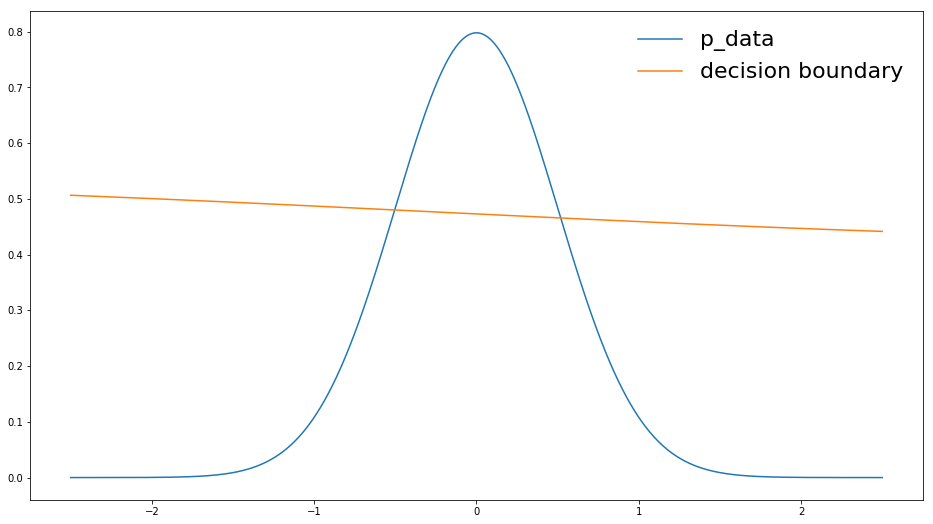

0.741435050964


In [13]:
#pretrain dicriminator

batch_size = 3000
pretrain_disc = True
if pretrain_disc ==True:
    
    for z in xrange(0,1):
        true_disc_x = gaussian(batch_size,mu=0., sigma=0.5)
        latent = noise_g(batch_size, mu=0., sigma=2.0)
        true_disc_y = np.zeros(batch_size)
        fake_disc_x = G.predict(latent)
        fake_disc_y = np.ones(batch_size)
        #x_disc = np.concatenate((true_disc_x, fake_disc_x))
        #x_disc = x_disc.reshape((x_disc.shape[0], 1))
        #y_disc = np.concatenate((true_disc_y, fake_disc_y))

        G.trainable = False
        D.trainable = True
        #d_loss_true = D.train_on_batch(true_disc_x, true_disc_y)
        #d_loss_fake = D.train_on_batch(fake_disc_x, fake_disc_y)
        d_loss = D.train_on_batch(true_disc_x, true_disc_y)
        d_loss = D.train_on_batch(fake_disc_x, fake_disc_y)
        plot_decision_boundary(D)
        print d_loss


Epoch 1, Discriminator loss:0.693587064743, GAN loss:0.692650556564
For true: mean and s.d. =  0.00318128611641 0.501866525258
For generator: mean and s.d. =  -0.0235346 0.486501


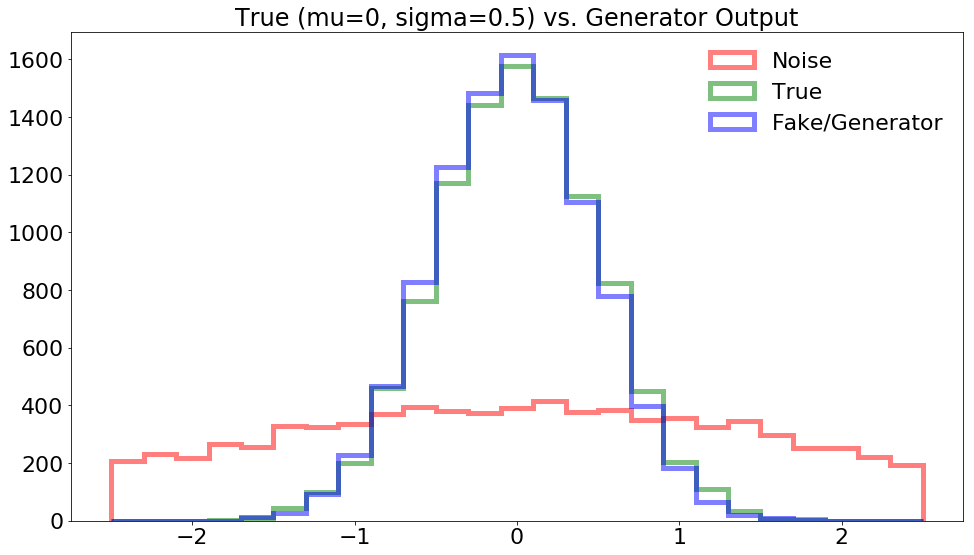

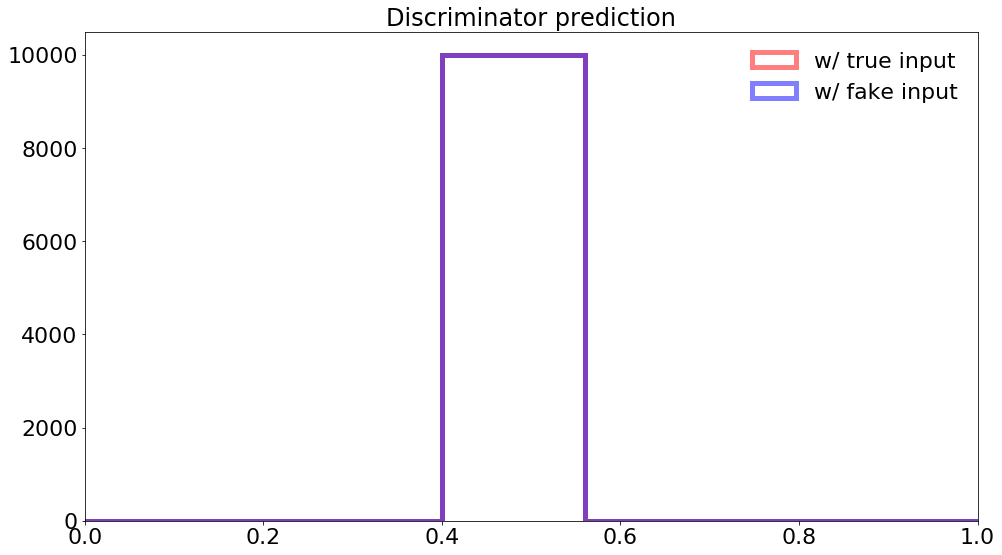

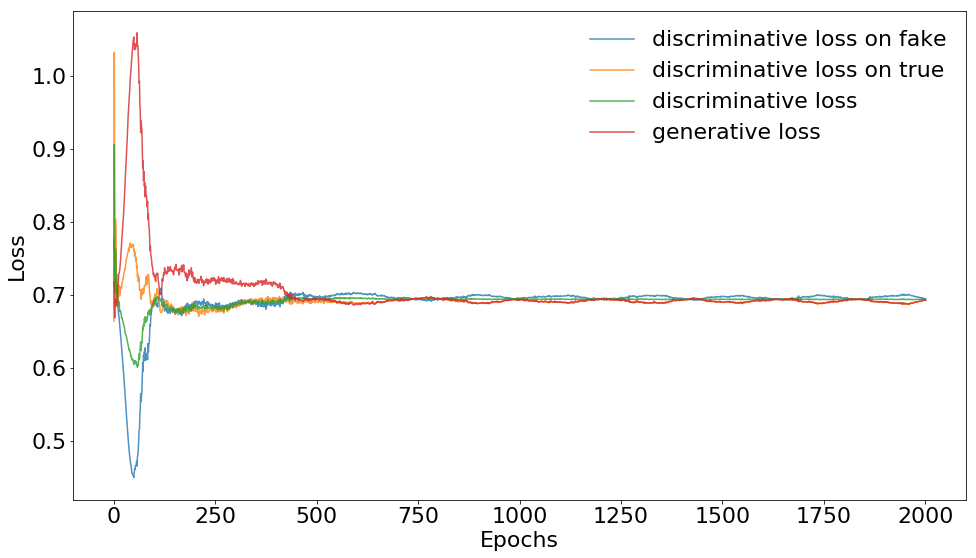

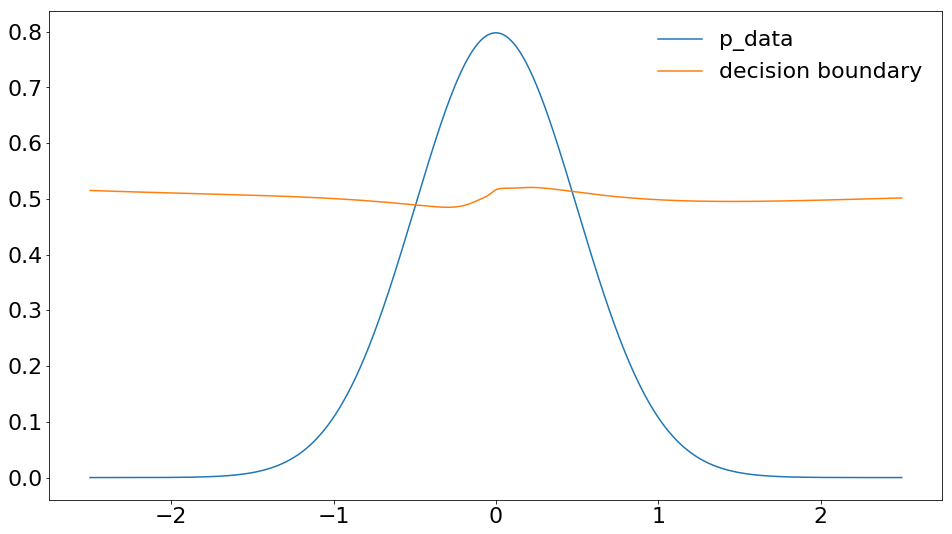

Epoch 51, Discriminator loss:0.693980455399, GAN loss:0.692673742771
For true: mean and s.d. =  -0.00646177954211 0.497330334002
For generator: mean and s.d. =  -0.00760427 0.489259


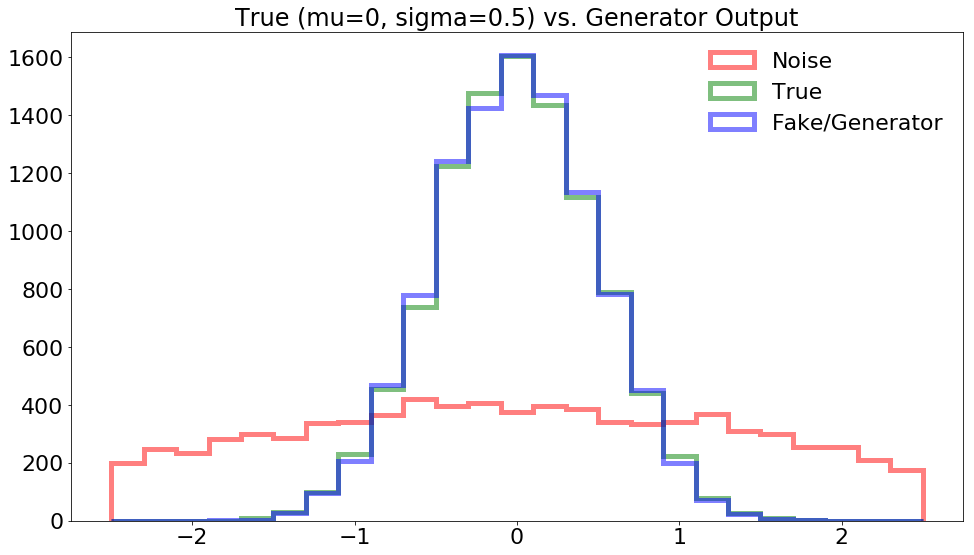

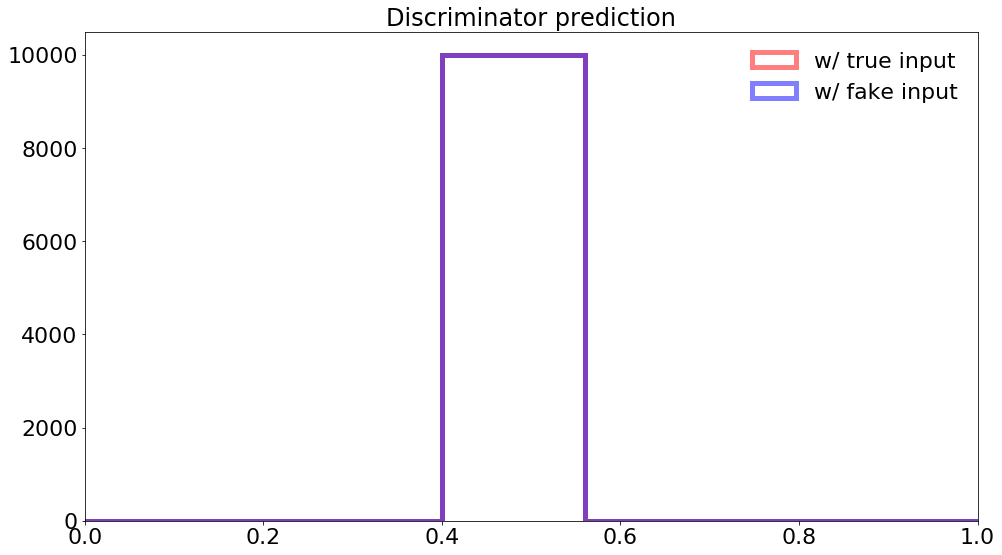

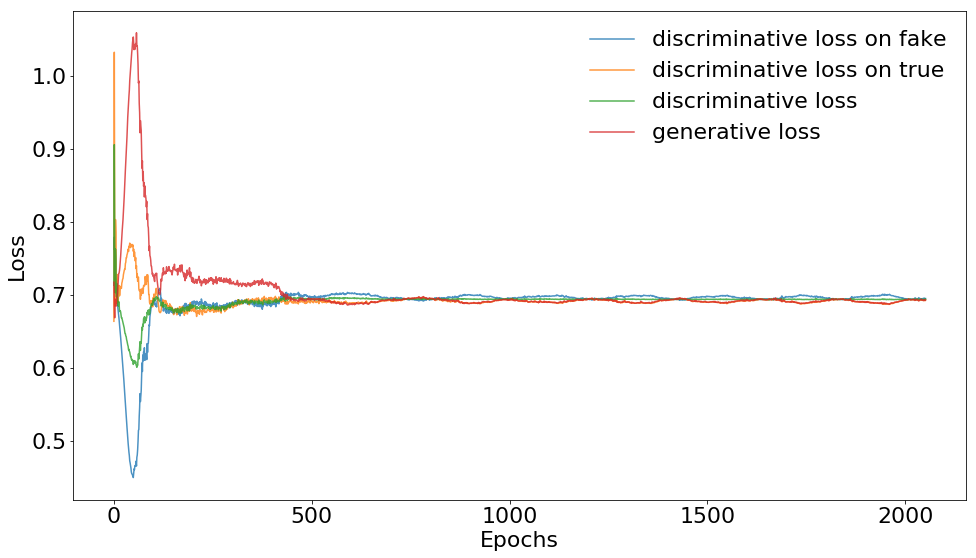

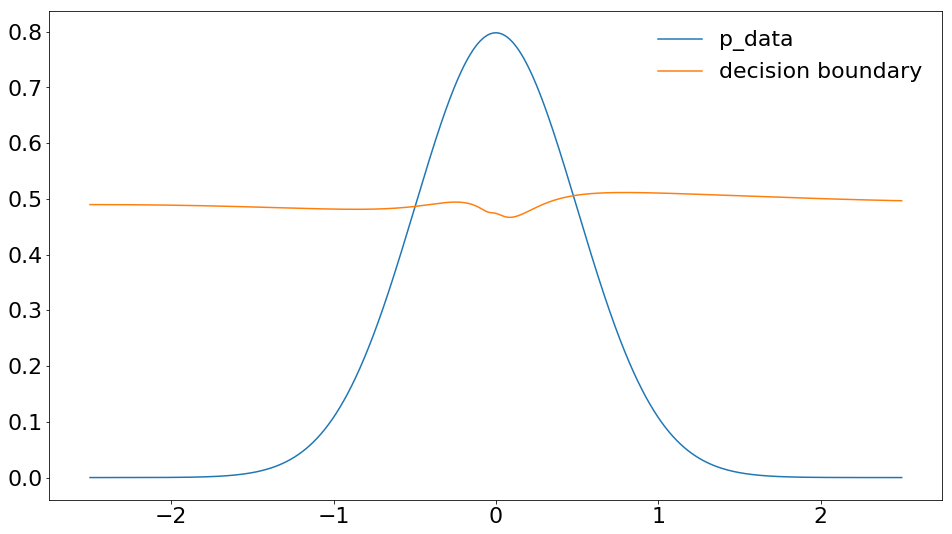

Epoch 101, Discriminator loss:0.694216012955, GAN loss:0.688682377338
For true: mean and s.d. =  0.00328318389583 0.491152577212
For generator: mean and s.d. =  -0.0195567 0.52329


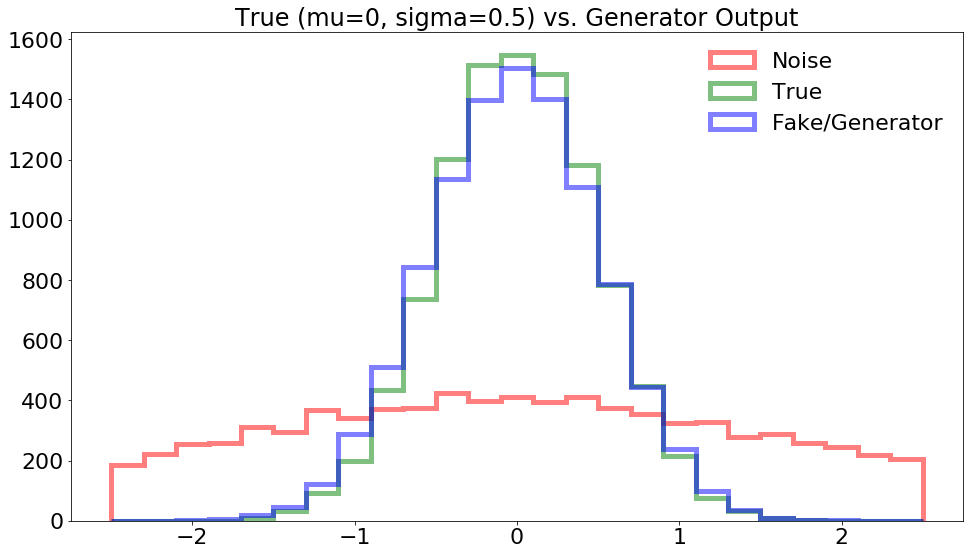

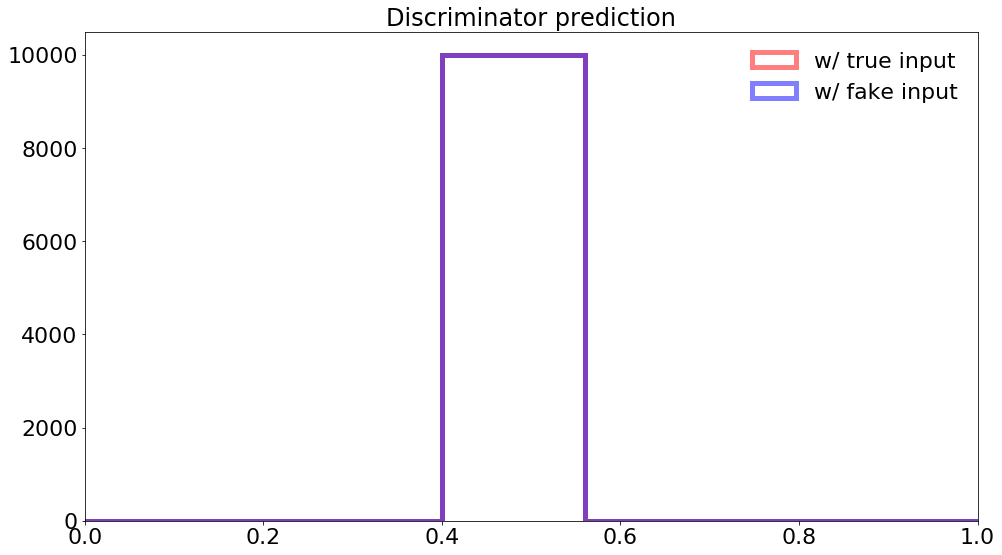

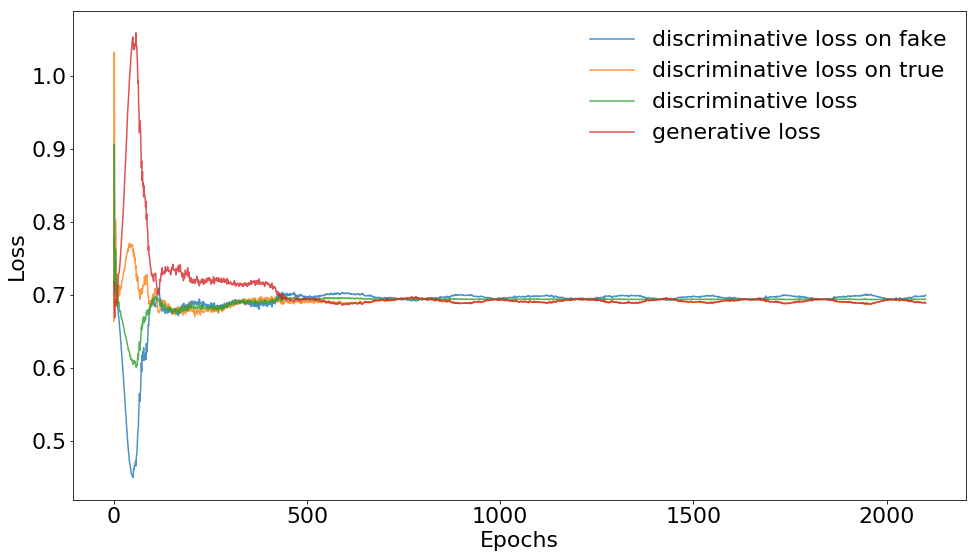

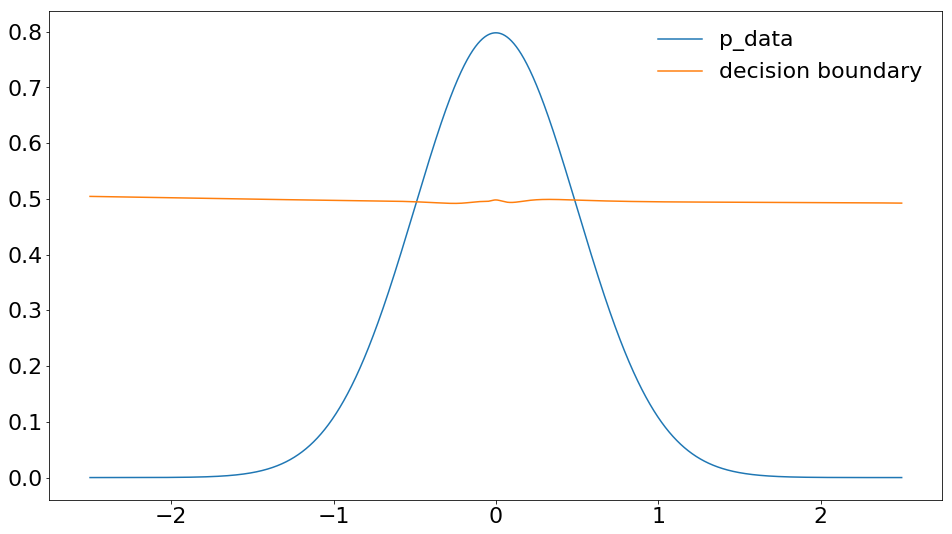

Epoch 151, Discriminator loss:0.693616092205, GAN loss:0.688914954662
For true: mean and s.d. =  -0.0132108571953 0.501641252855
For generator: mean and s.d. =  -0.0296391 0.501671


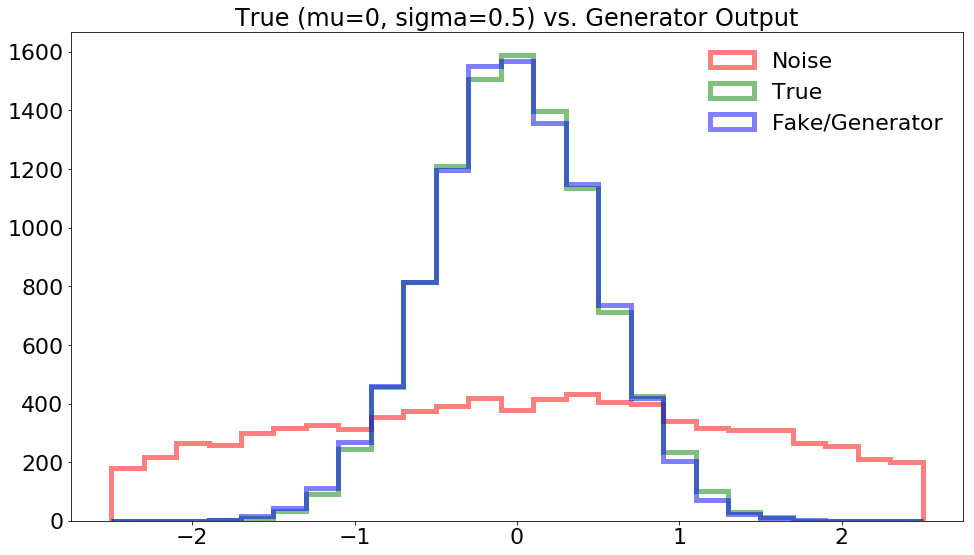

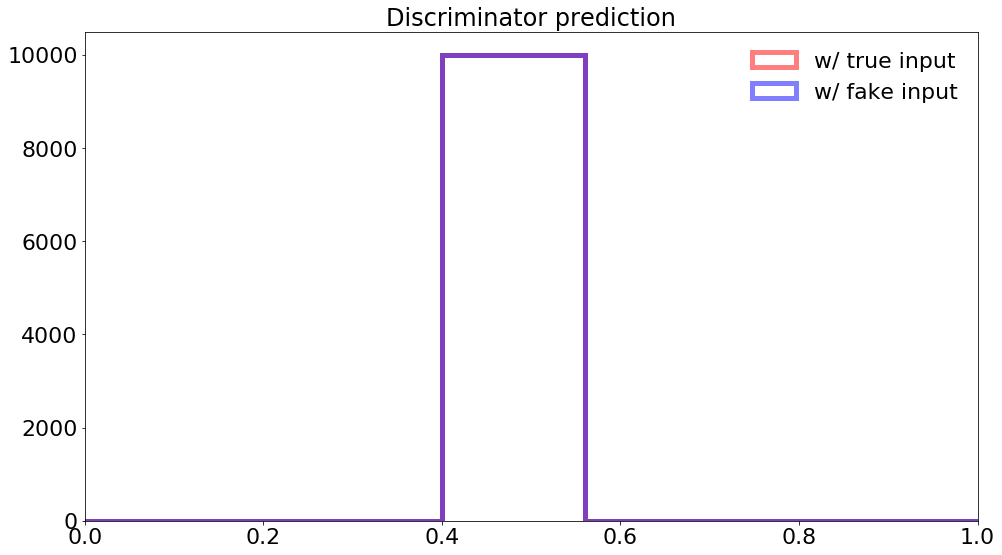

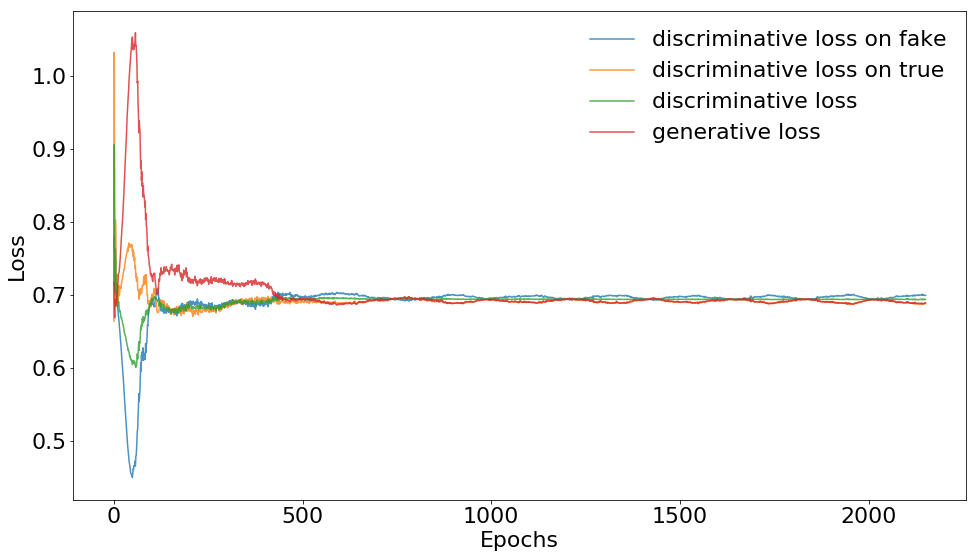

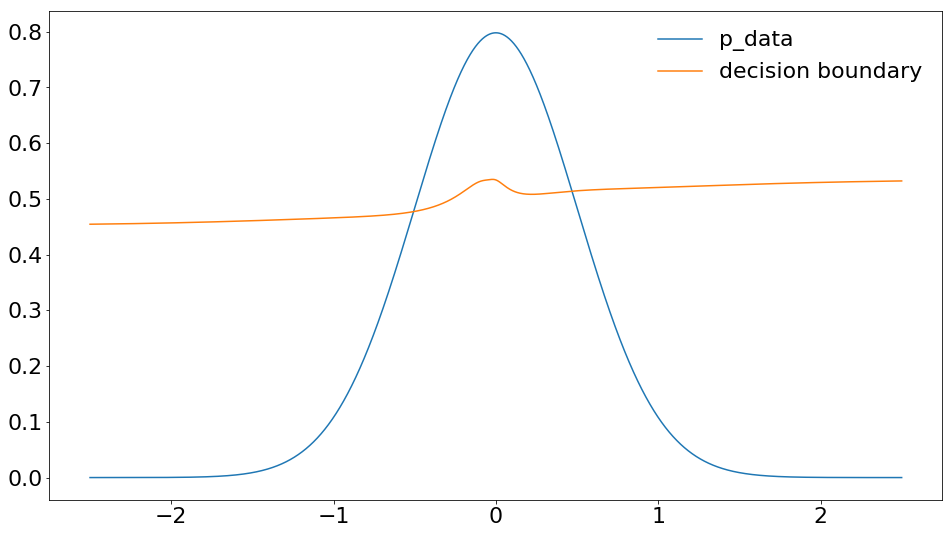

Epoch 201, Discriminator loss:0.69343984127, GAN loss:0.695484399796
For true: mean and s.d. =  -0.000110540554453 0.506844016741
For generator: mean and s.d. =  -0.0275908 0.468666


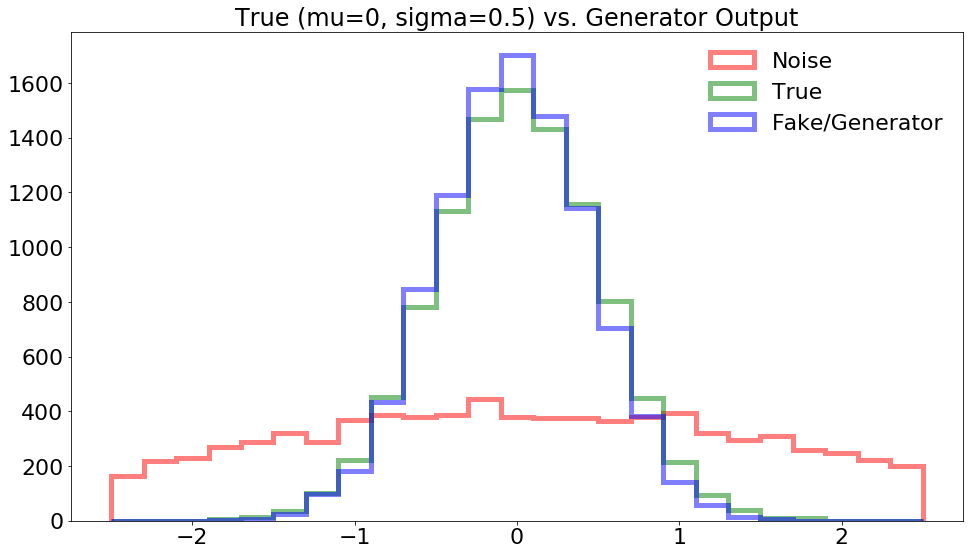

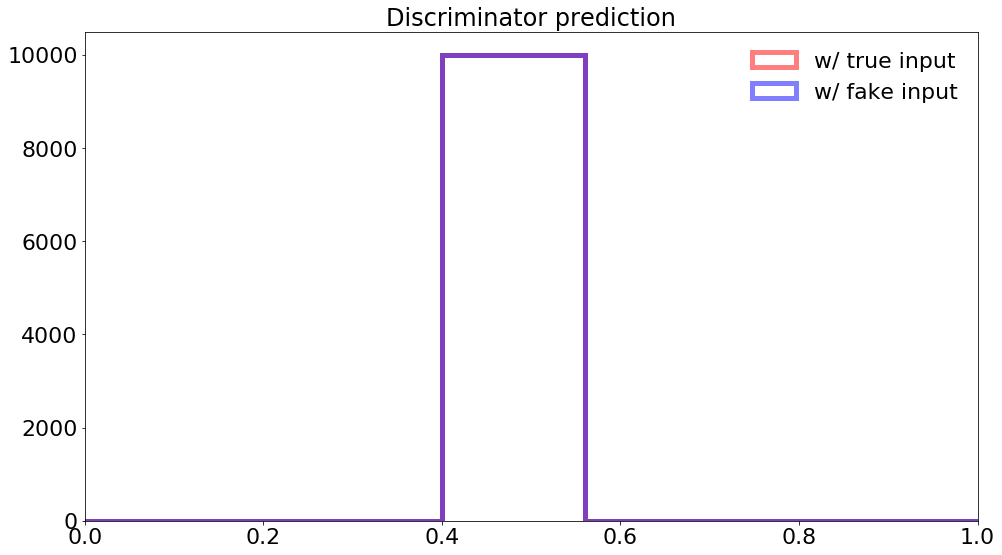

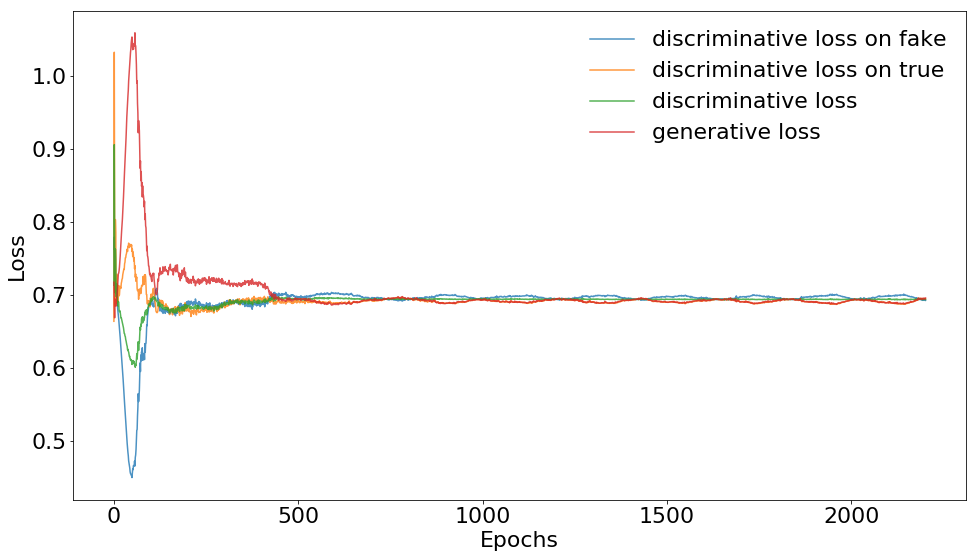

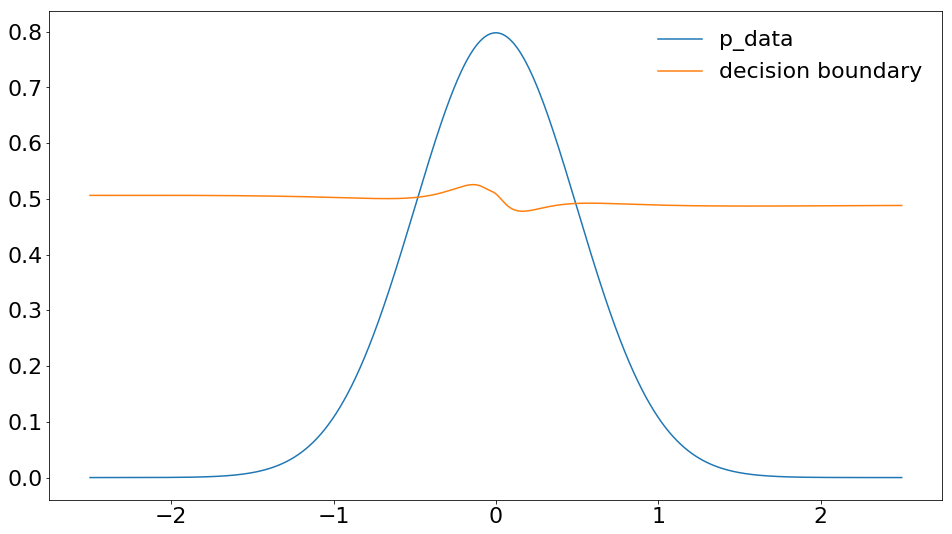

Epoch 251, Discriminator loss:0.693848013878, GAN loss:0.689791023731
For true: mean and s.d. =  -0.000620414403858 0.499773548743
For generator: mean and s.d. =  -0.0165042 0.500761


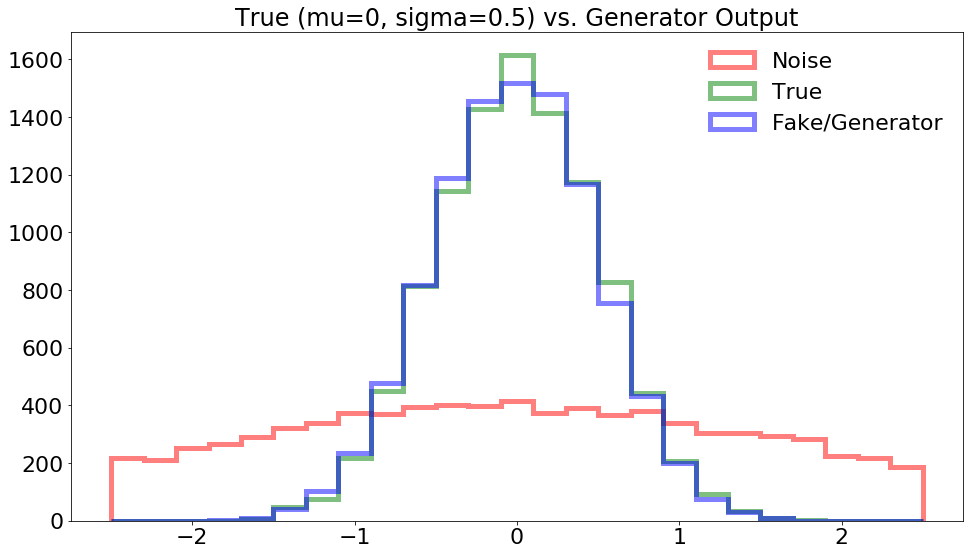

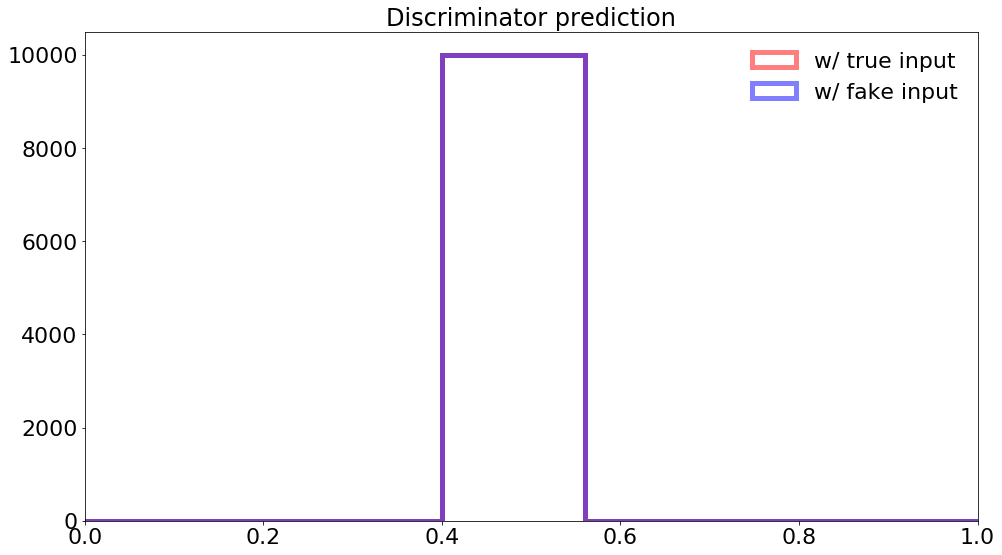

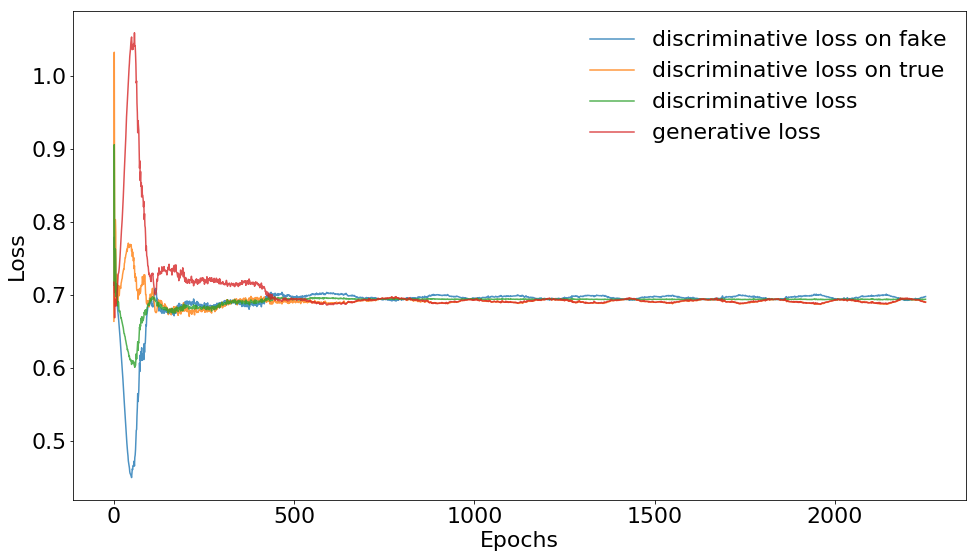

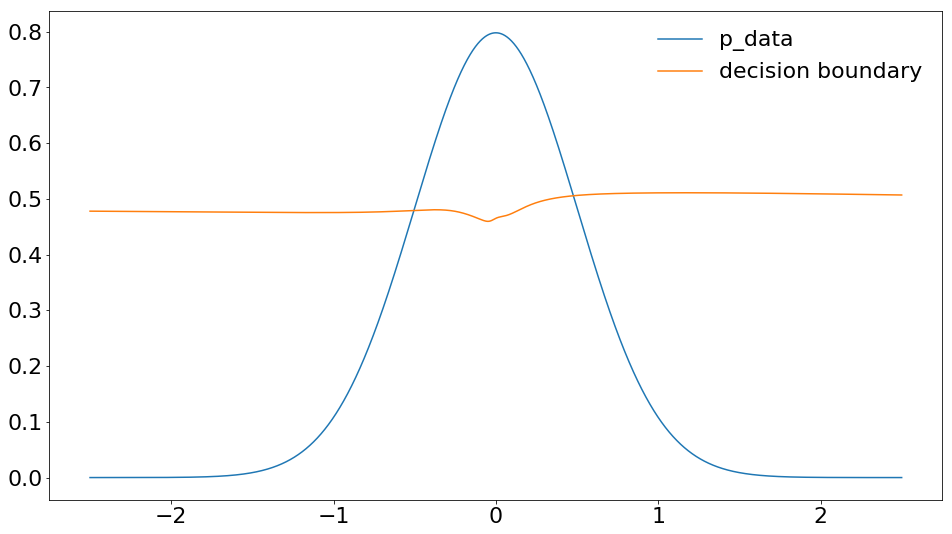

Epoch 301, Discriminator loss:0.693552732468, GAN loss:0.688074290752
For true: mean and s.d. =  -0.00782144332546 0.502013210588
For generator: mean and s.d. =  -0.0165593 0.530772


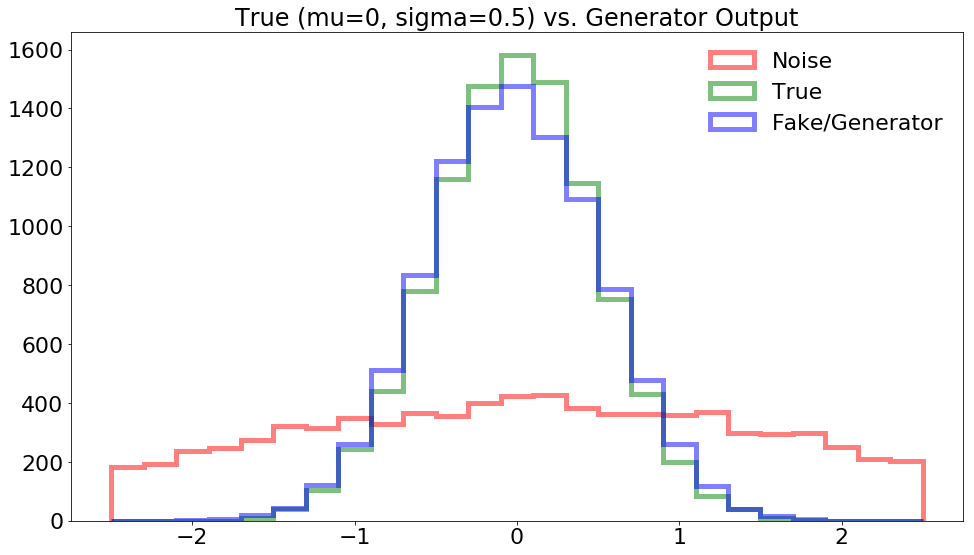

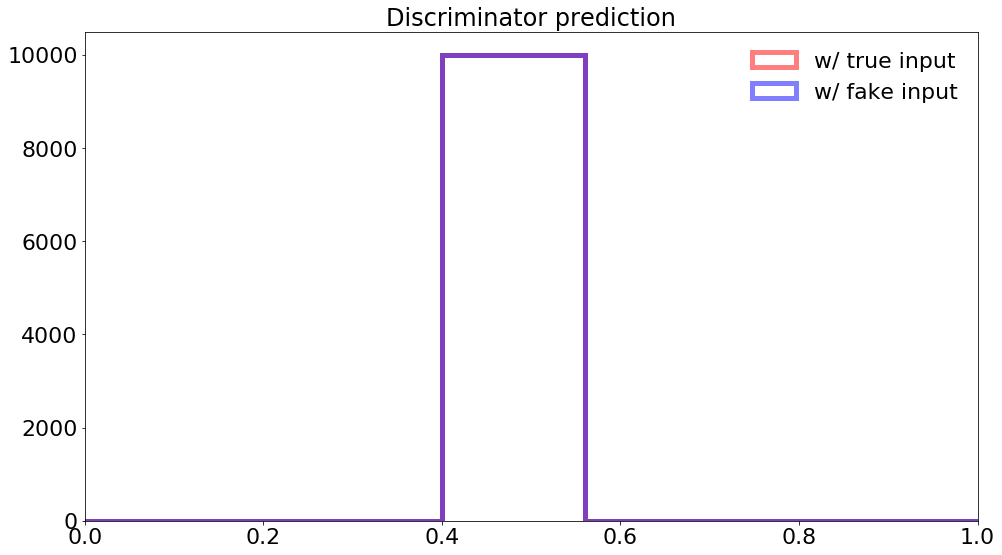

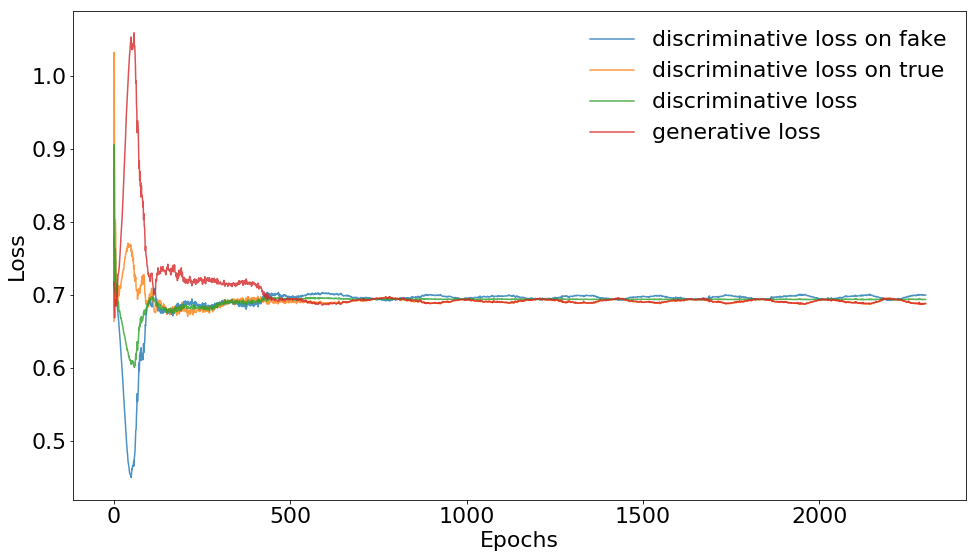

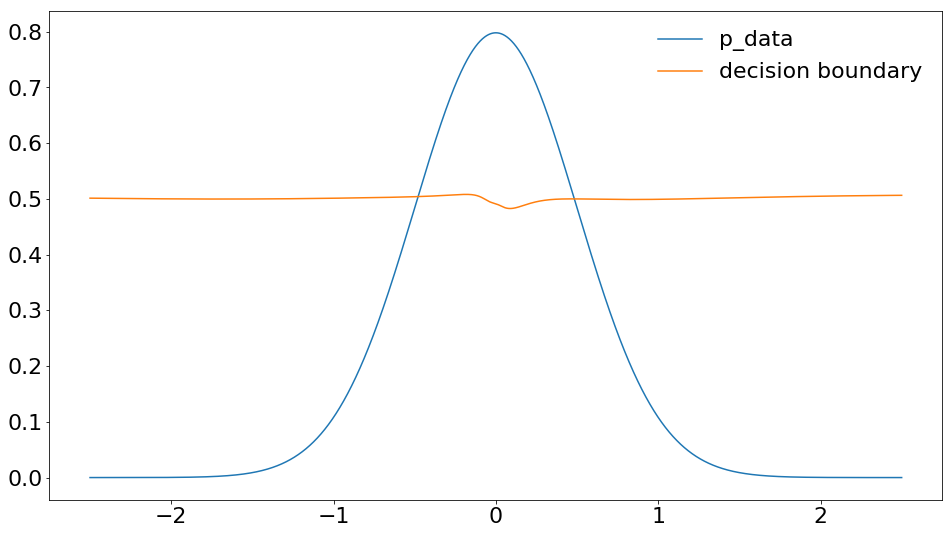

Epoch 351, Discriminator loss:0.693758547306, GAN loss:0.69151955843
For true: mean and s.d. =  0.00381027576533 0.499903262091
For generator: mean and s.d. =  -0.00344104 0.492849


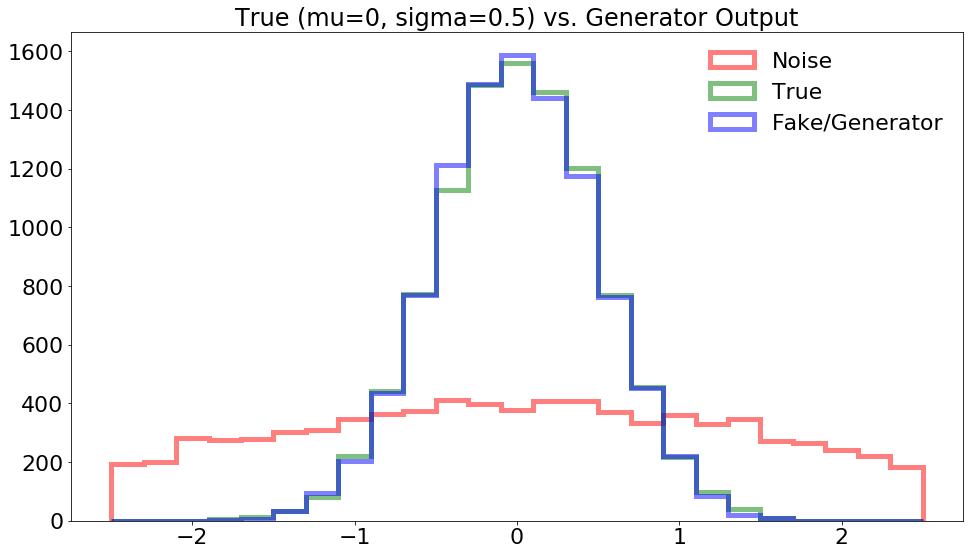

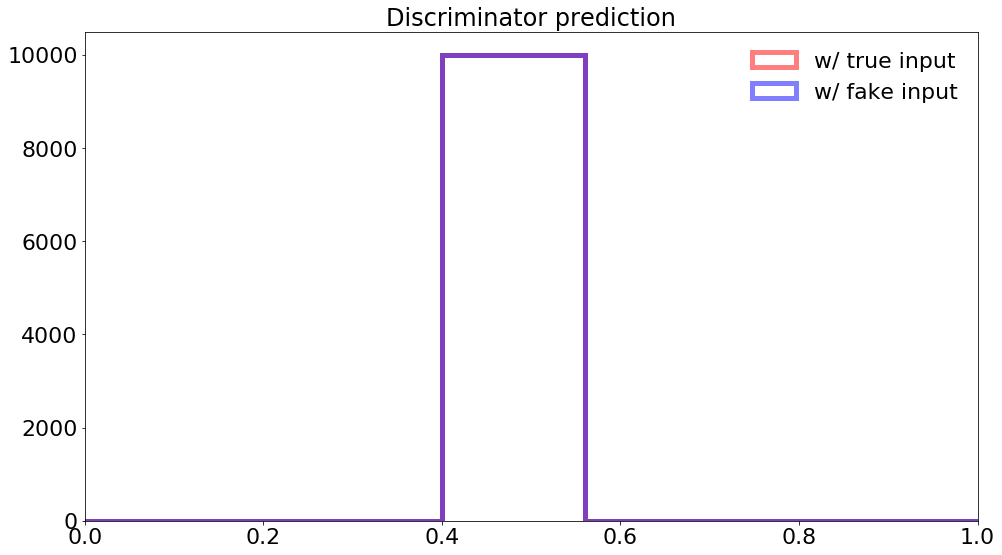

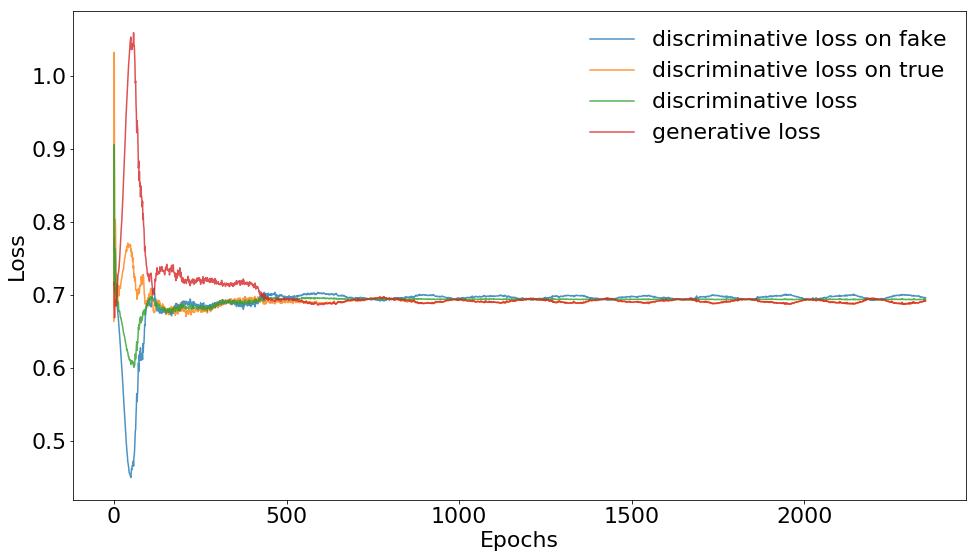

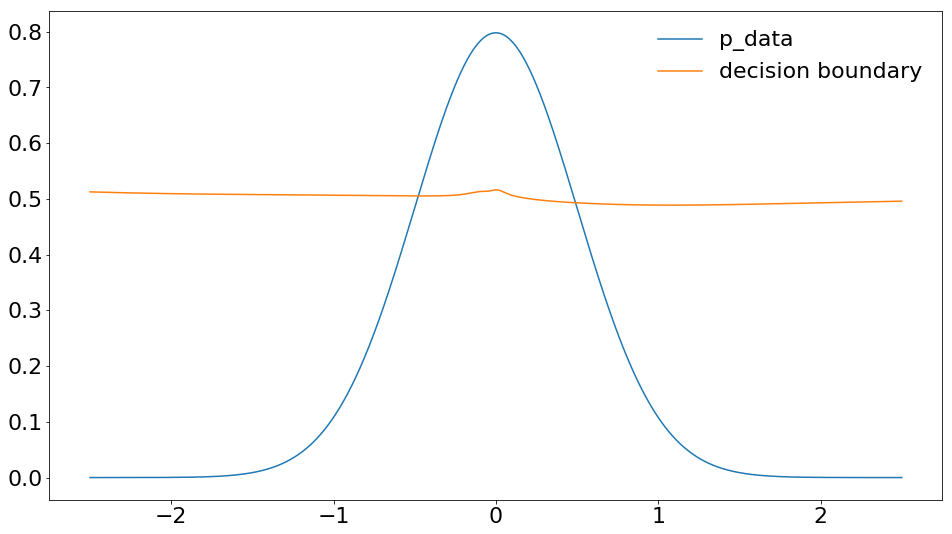

Epoch 401, Discriminator loss:0.693474113941, GAN loss:0.692838668823
For true: mean and s.d. =  -0.00385343158492 0.498521843627
For generator: mean and s.d. =  0.000431628 0.474089


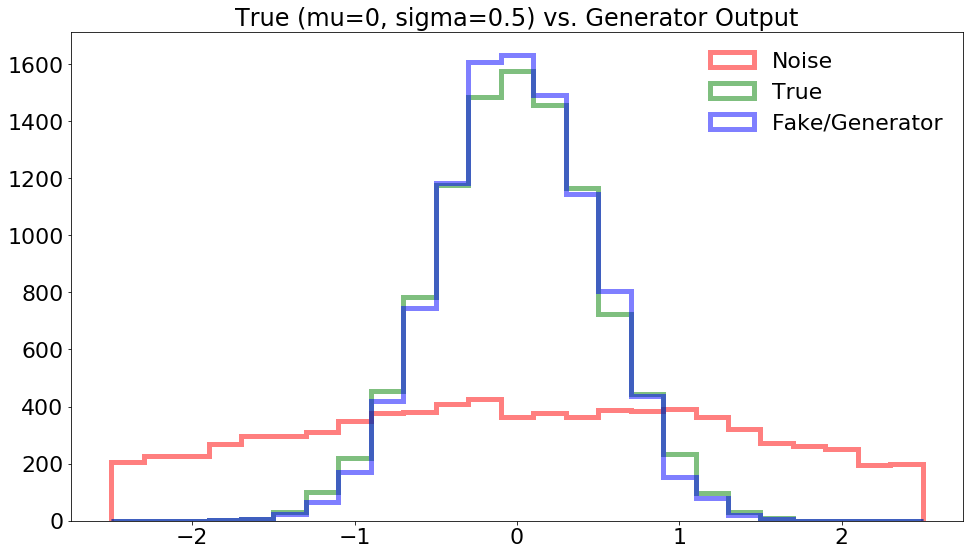

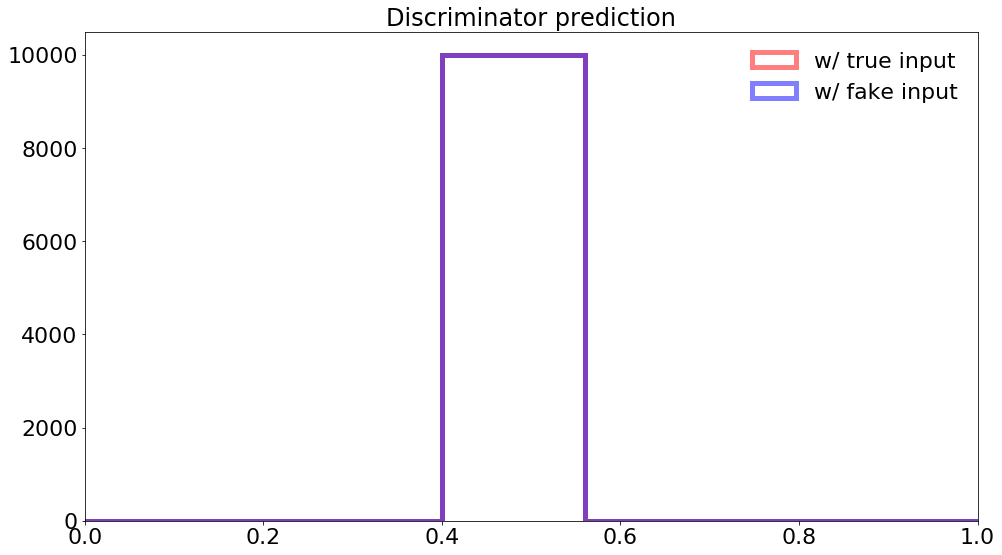

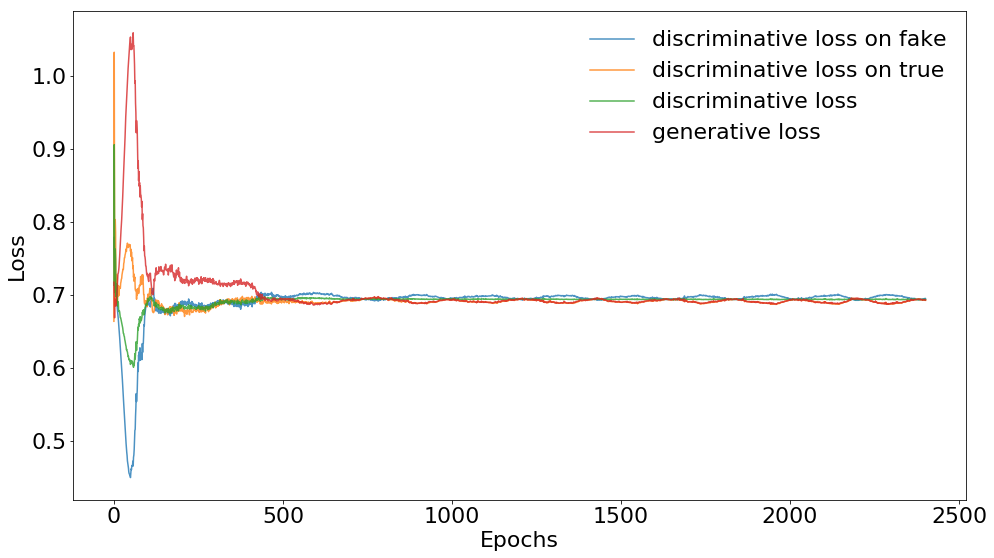

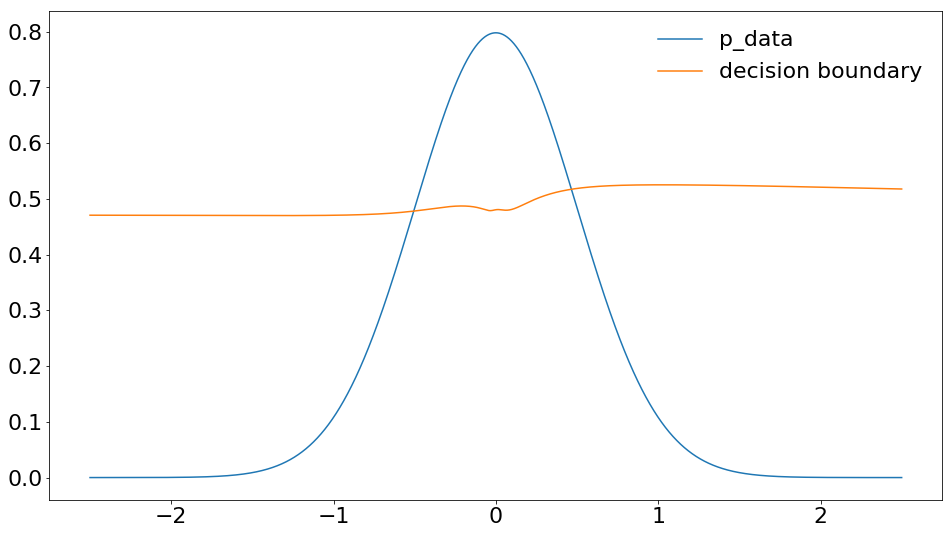

Epoch 451, Discriminator loss:0.693993091583, GAN loss:0.689393460751
For true: mean and s.d. =  0.00398162478354 0.493927373906
For generator: mean and s.d. =  0.00963258 0.516182


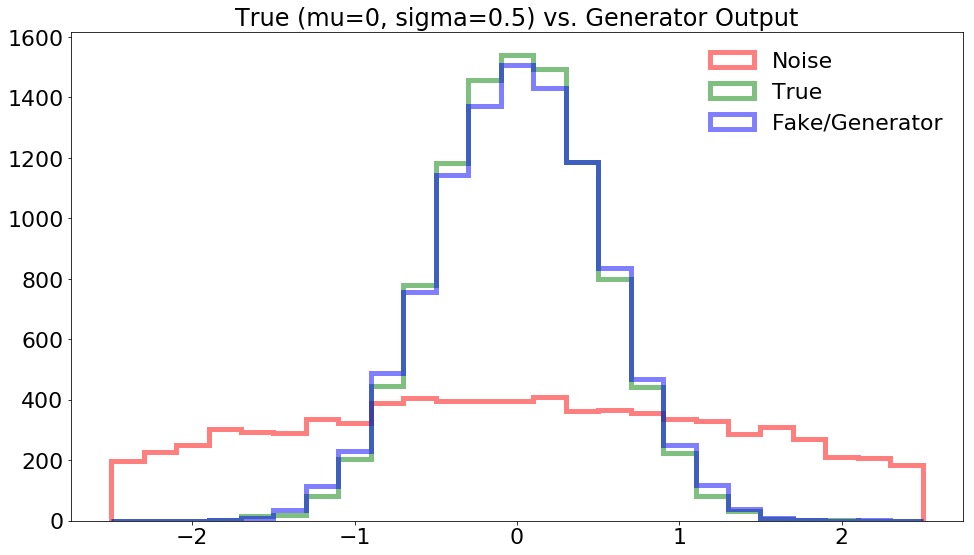

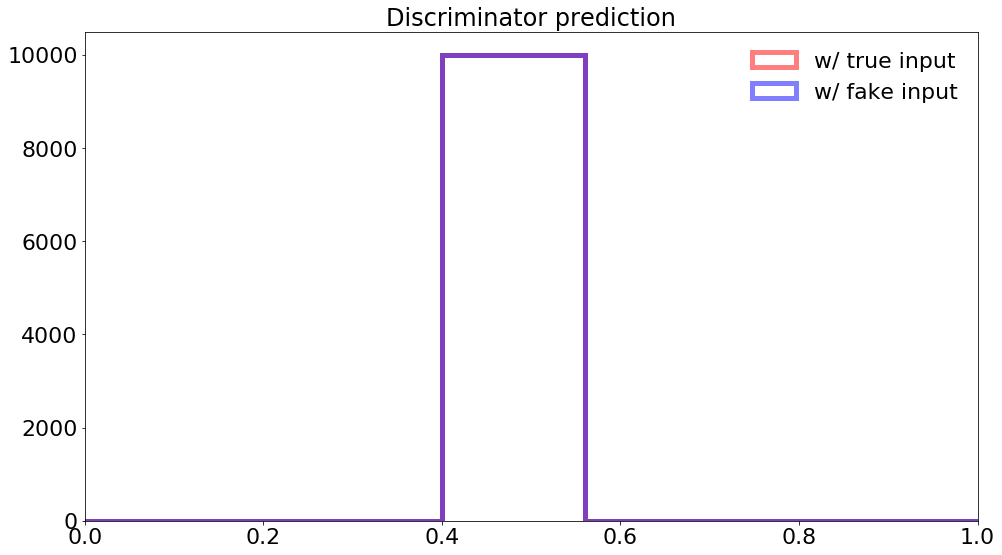

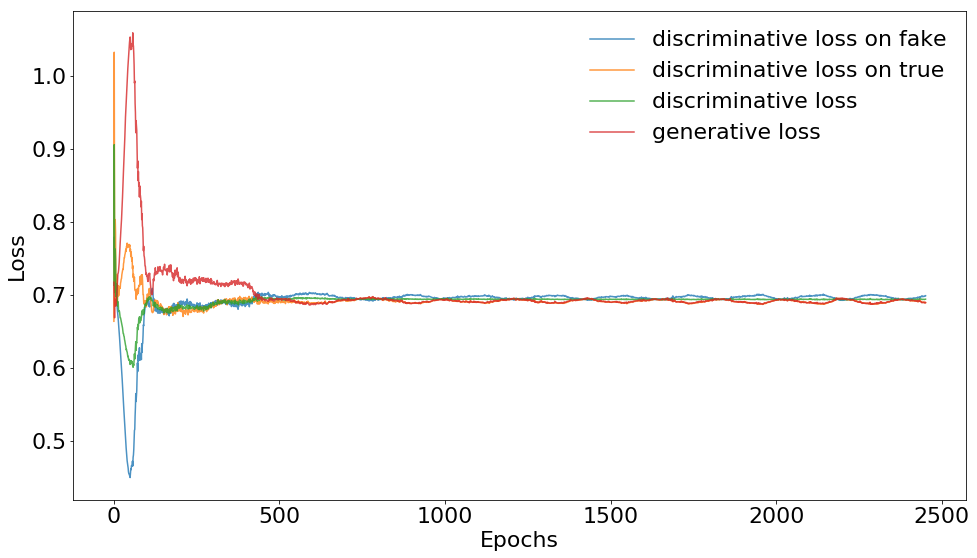

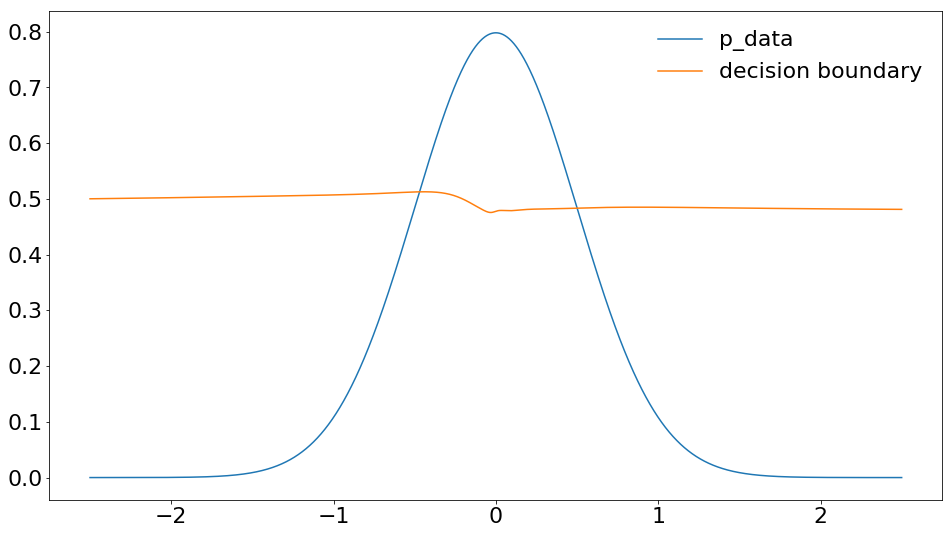

Epoch 501, Discriminator loss:0.693464934826, GAN loss:0.688787817955
For true: mean and s.d. =  0.00233000988167 0.504930632328
For generator: mean and s.d. =  0.00543926 0.528174


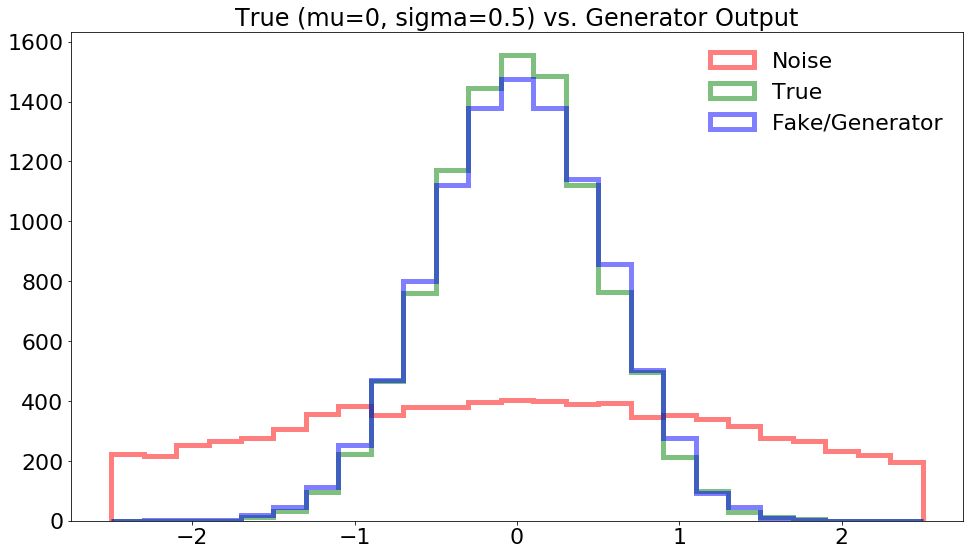

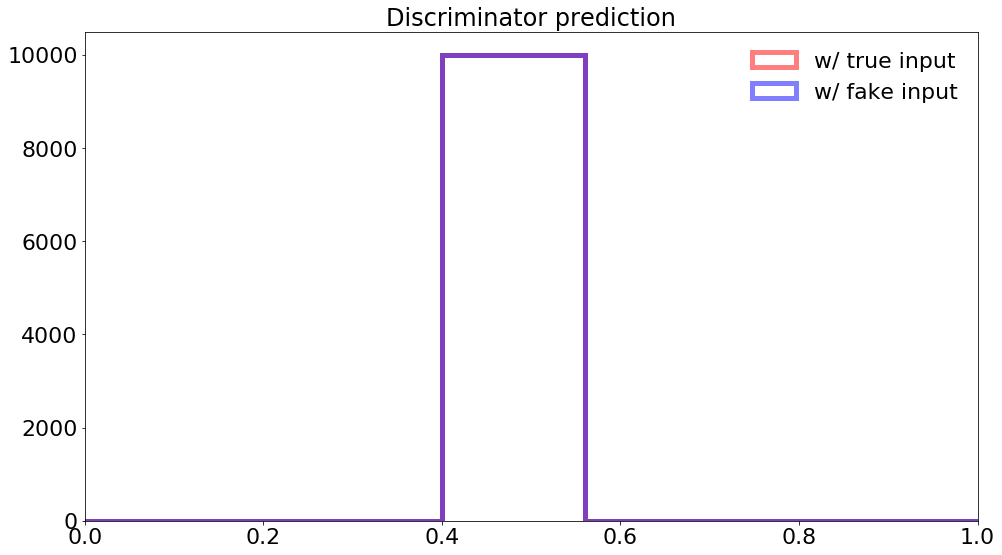

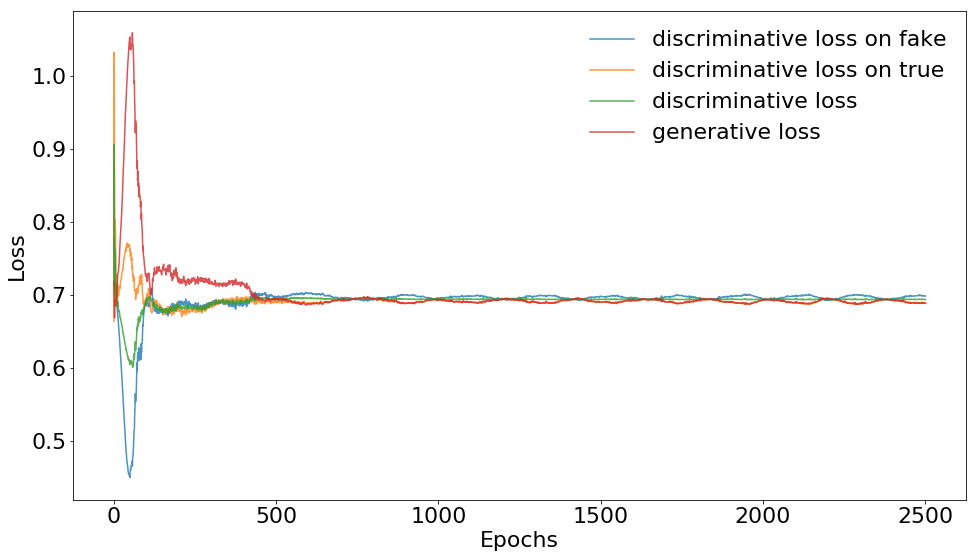

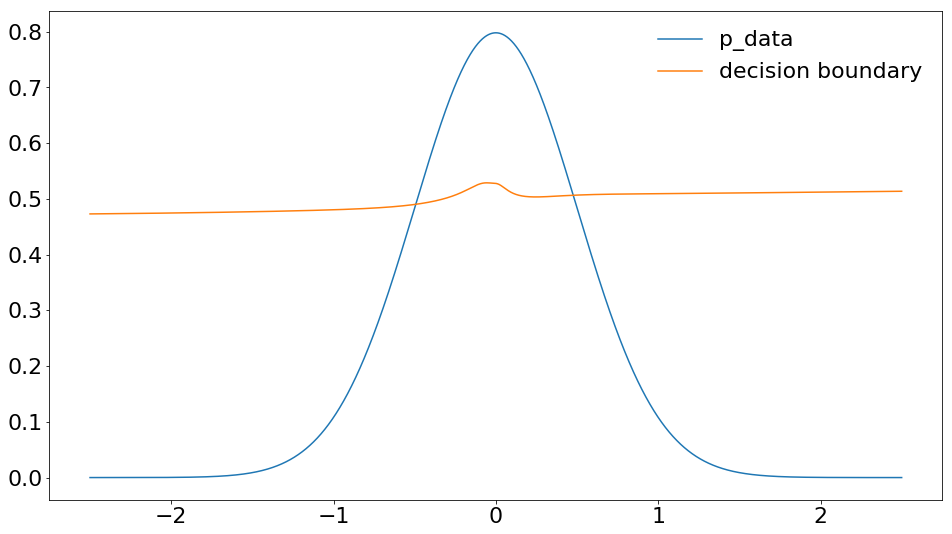

Epoch 551, Discriminator loss:0.693712353706, GAN loss:0.691600084305
For true: mean and s.d. =  0.00629915742769 0.499148395847
For generator: mean and s.d. =  0.00459498 0.497133


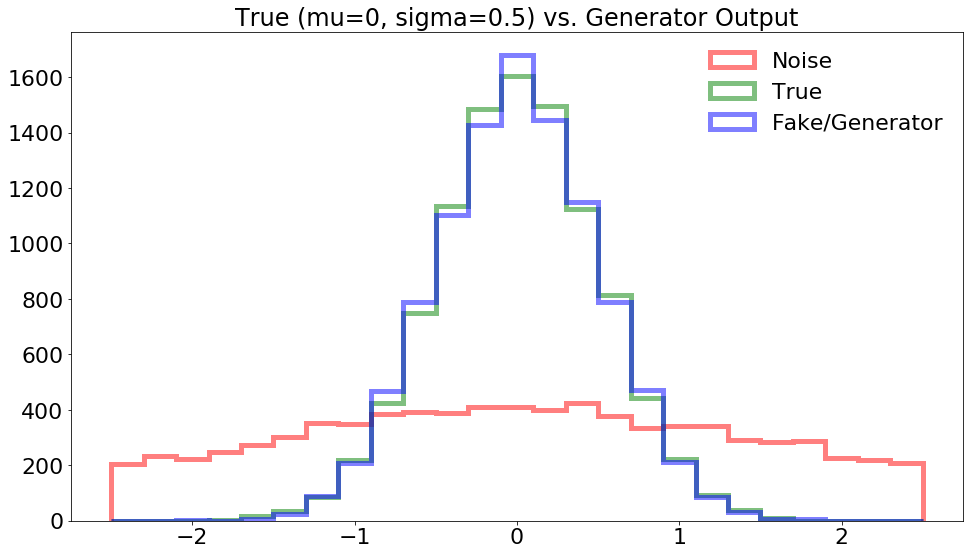

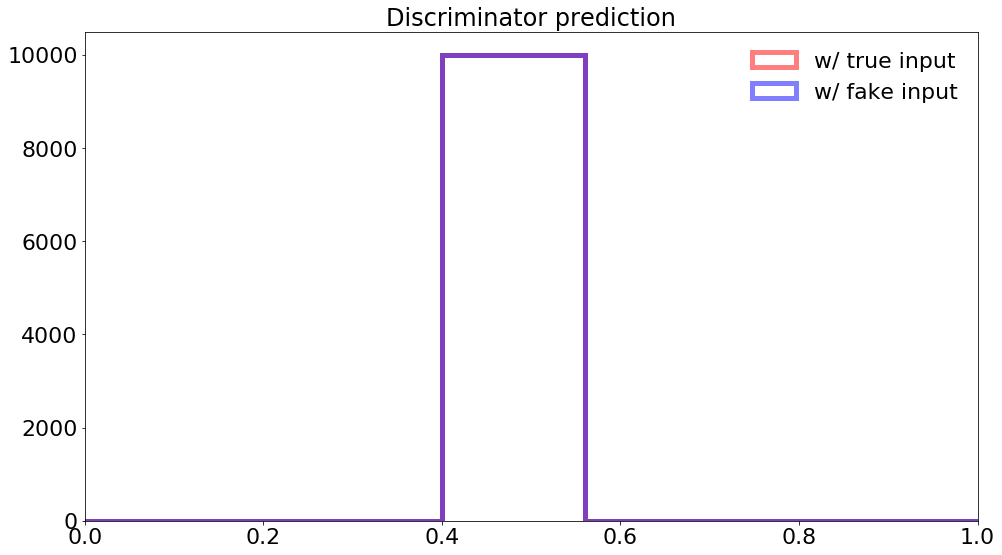

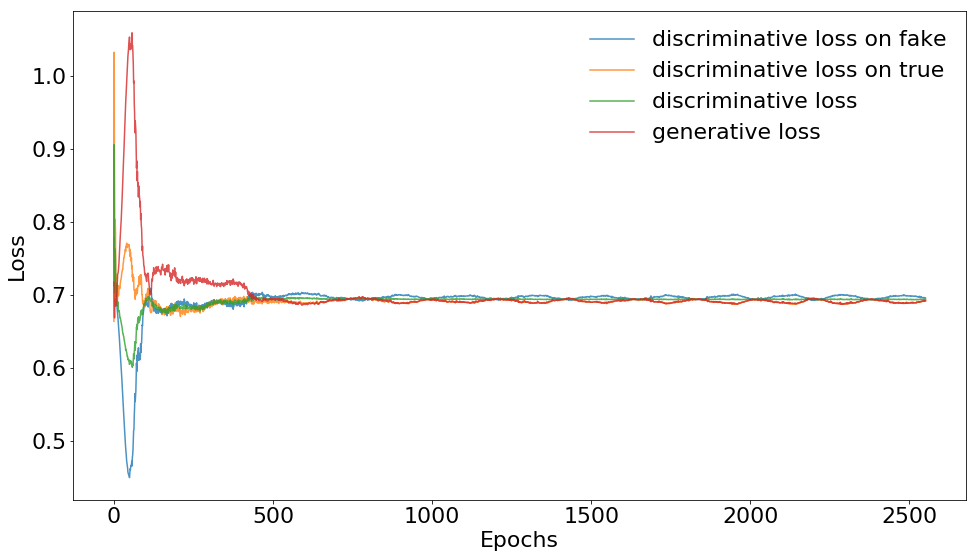

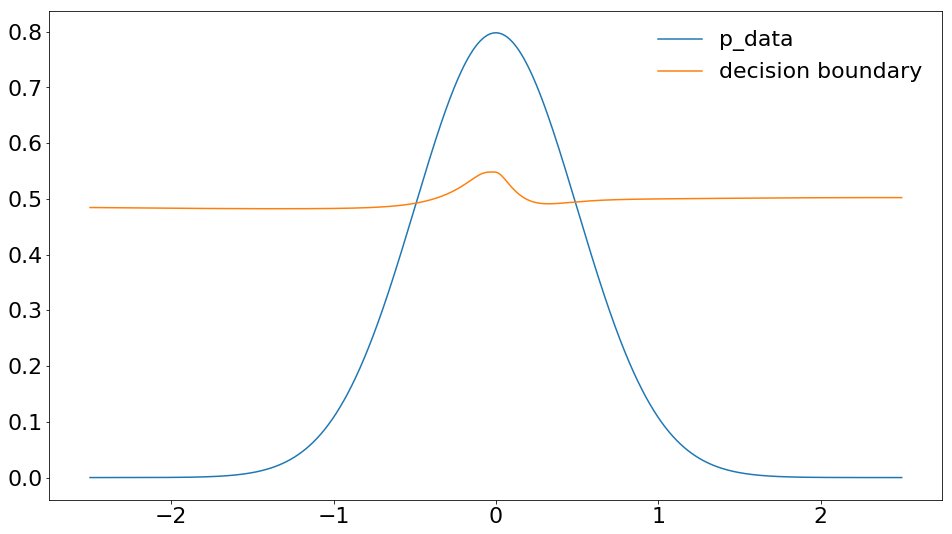

Epoch 601, Discriminator loss:0.693854212761, GAN loss:0.6939868927
For true: mean and s.d. =  -0.00114300058115 0.502650710476
For generator: mean and s.d. =  0.0136483 0.480031


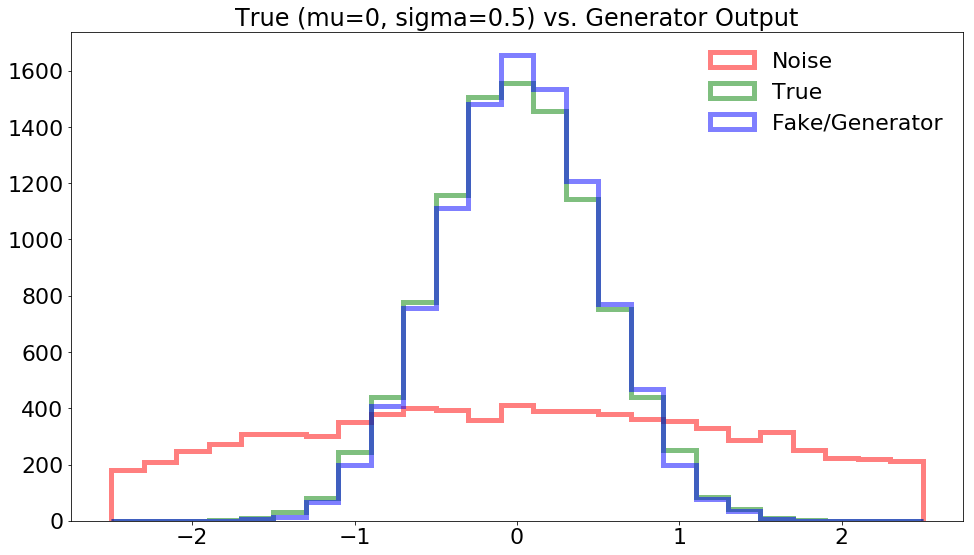

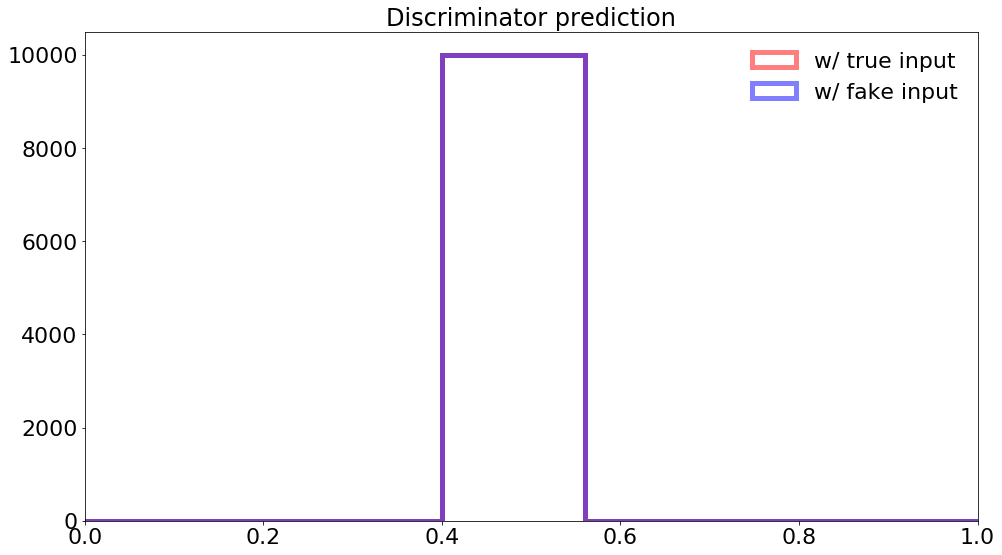

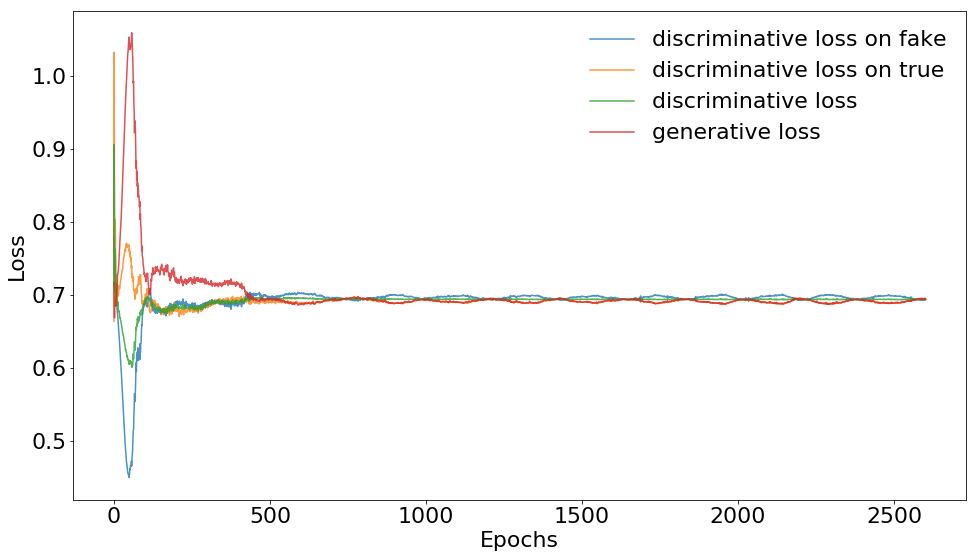

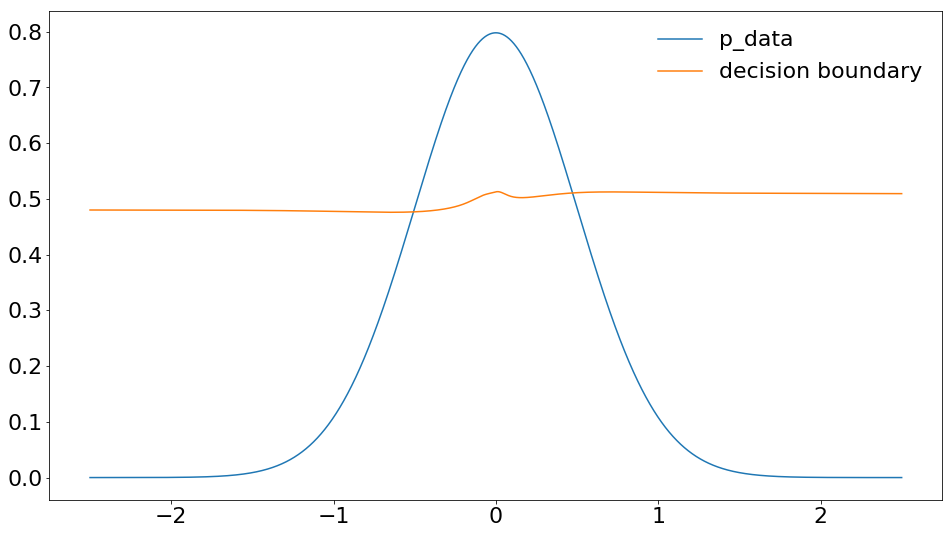

Epoch 651, Discriminator loss:0.694034695625, GAN loss:0.690984129906
For true: mean and s.d. =  -0.00329325479006 0.494741981078
For generator: mean and s.d. =  0.0260652 0.504118


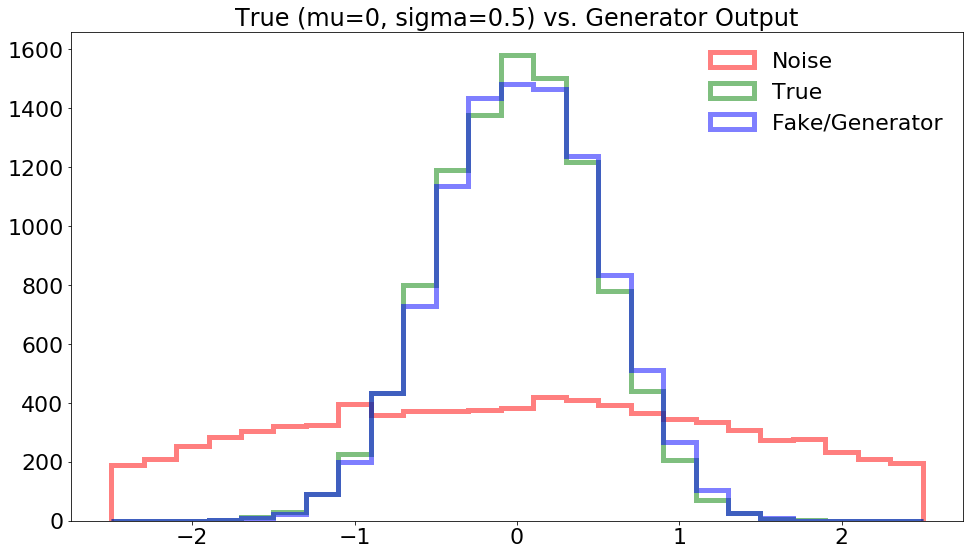

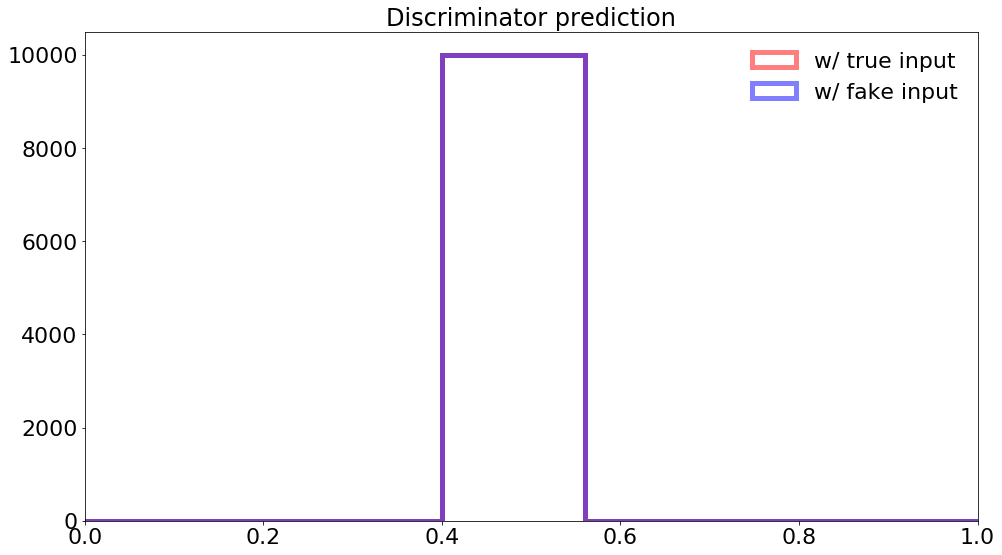

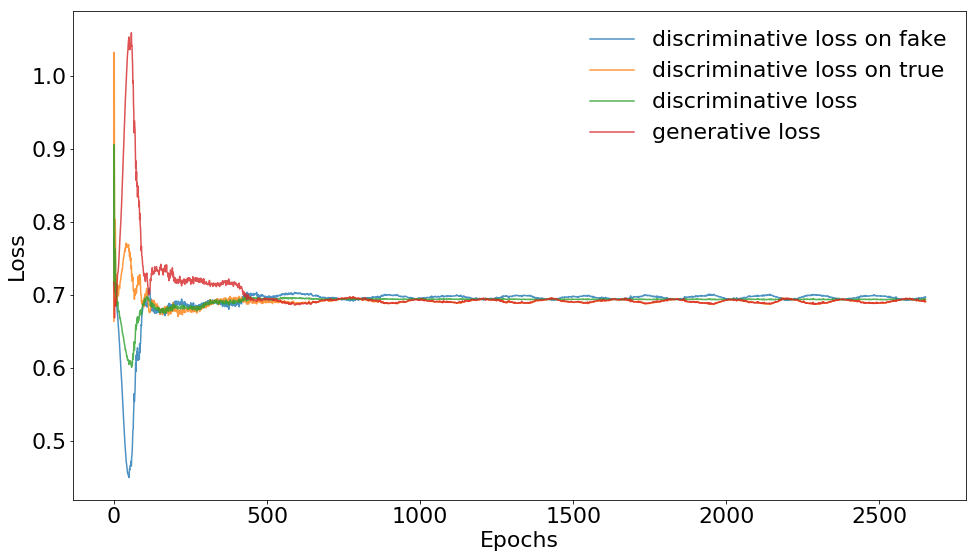

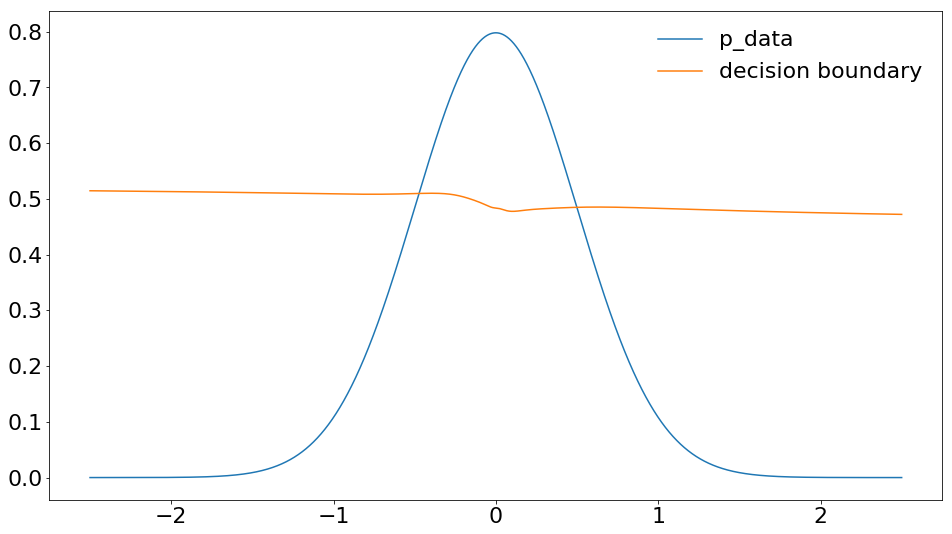

Epoch 701, Discriminator loss:0.693420648575, GAN loss:0.687821805477
For true: mean and s.d. =  0.00274007472644 0.502167769265
For generator: mean and s.d. =  0.0184134 0.528035


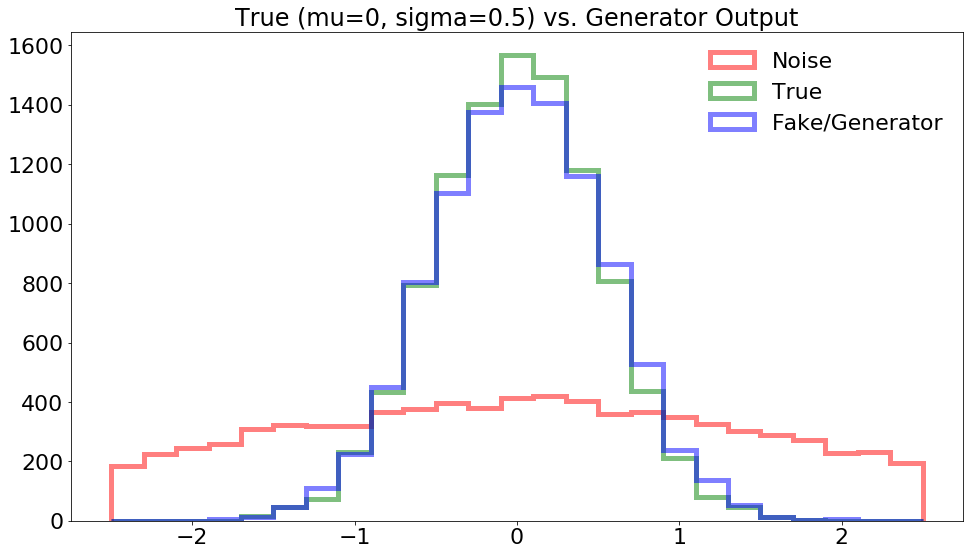

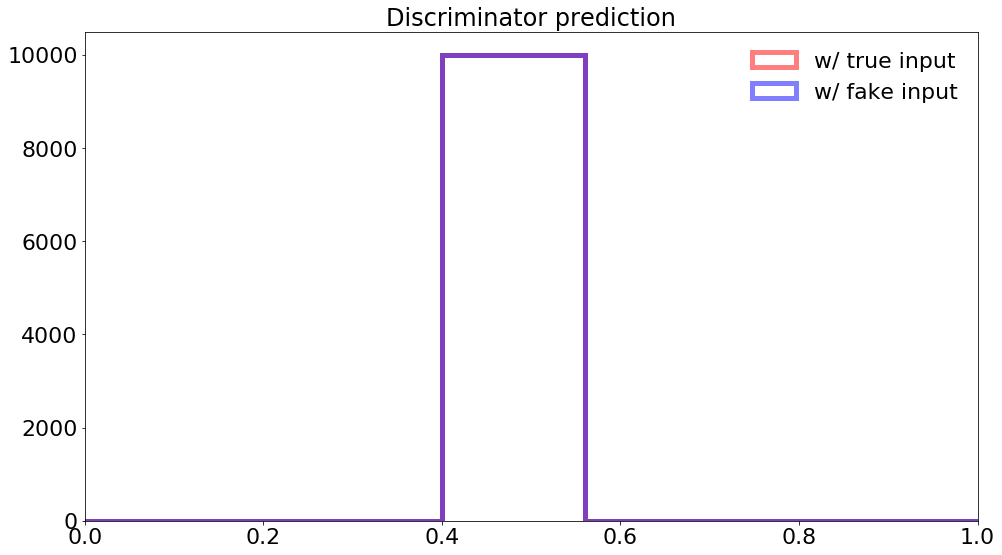

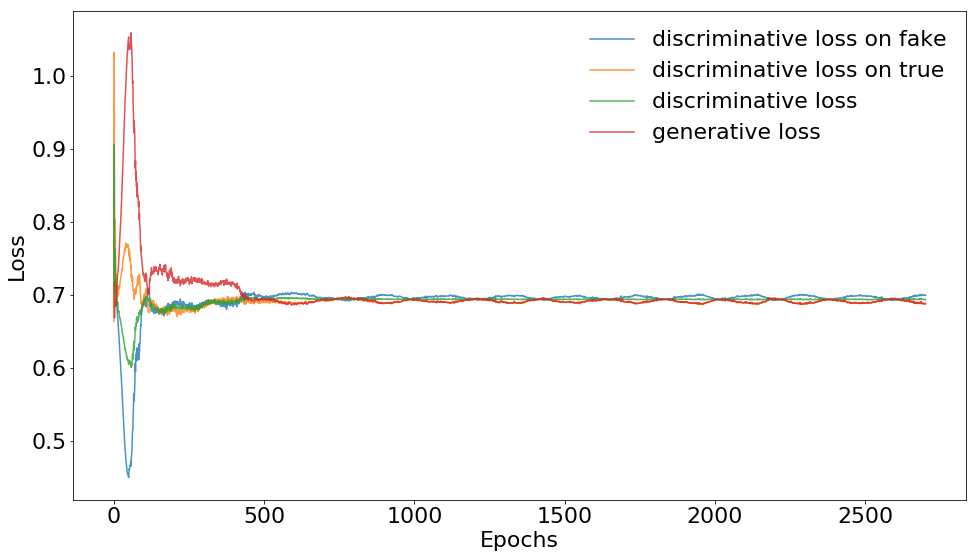

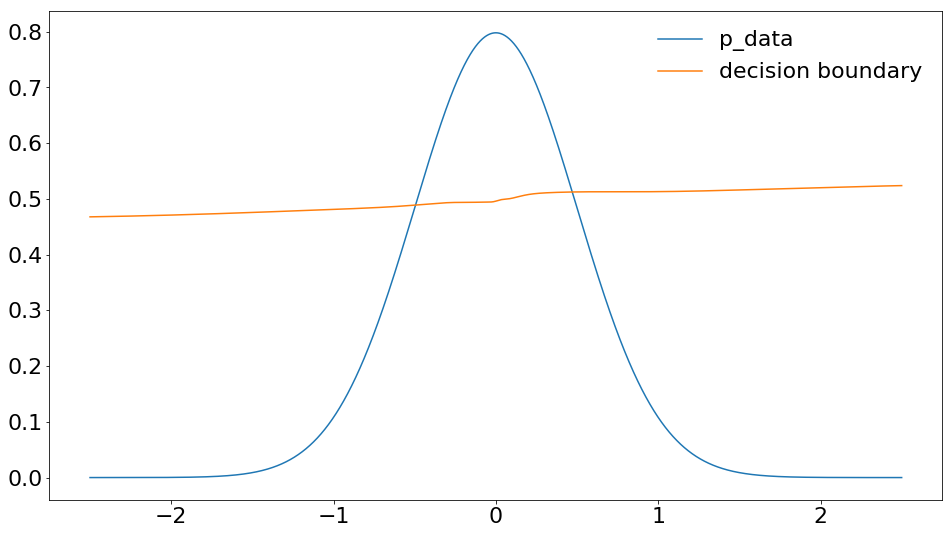

Epoch 751, Discriminator loss:0.693700432777, GAN loss:0.691290974617
For true: mean and s.d. =  0.00544316943539 0.501120373933
For generator: mean and s.d. =  0.017261 0.493642


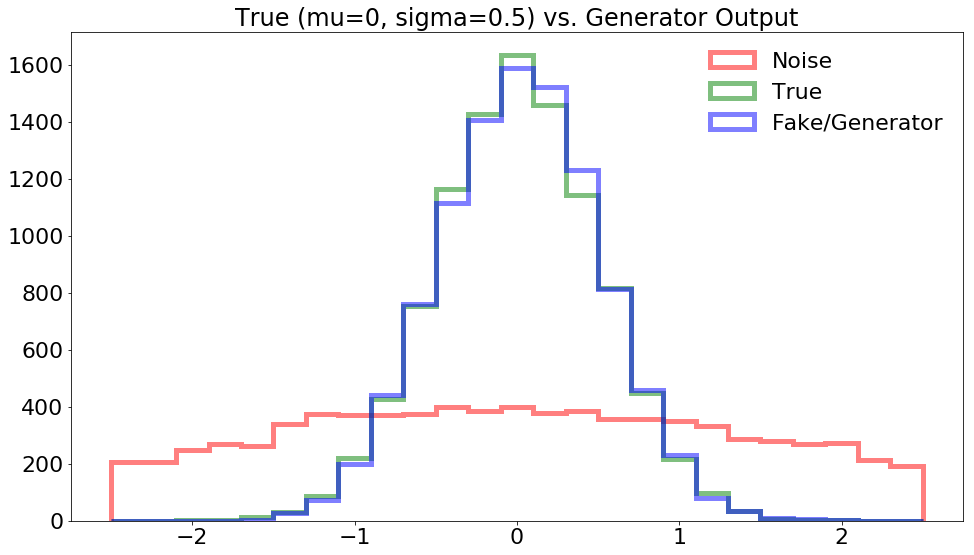

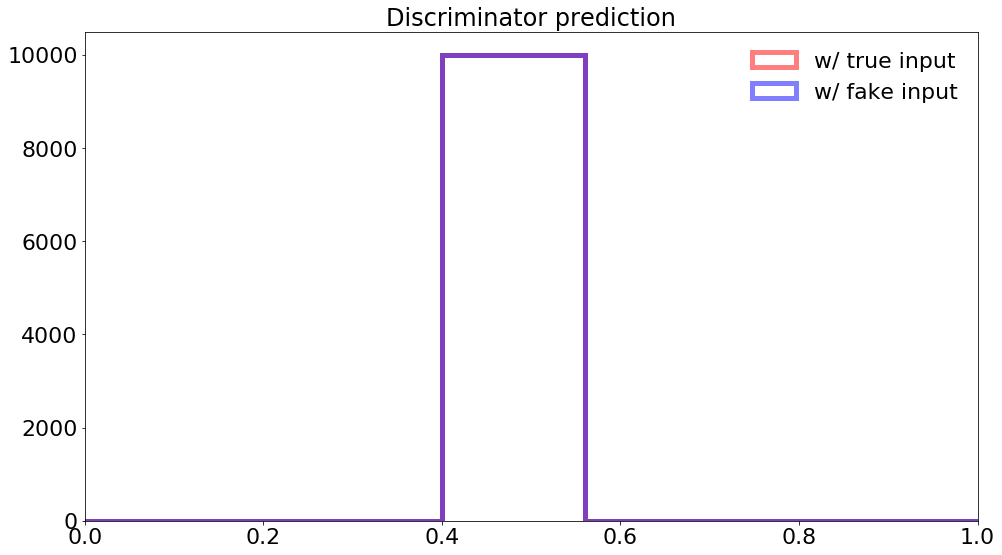

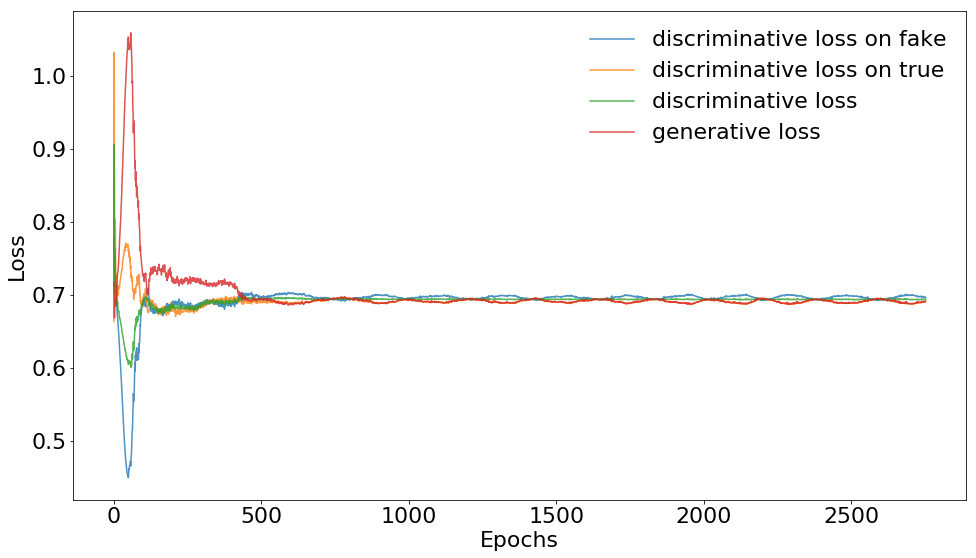

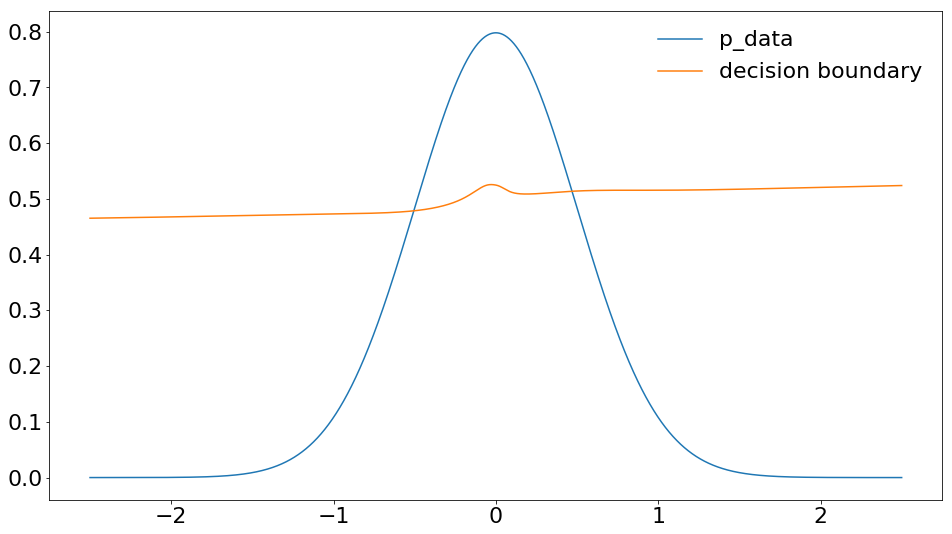

Epoch 801, Discriminator loss:0.693229794502, GAN loss:0.694221138954
For true: mean and s.d. =  0.00987538660135 0.495597428854
For generator: mean and s.d. =  0.0148718 0.476896


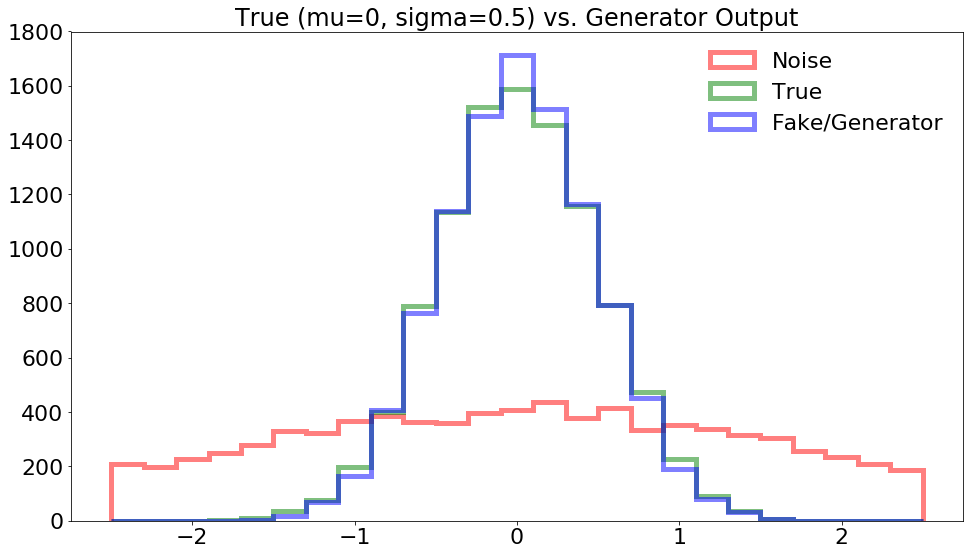

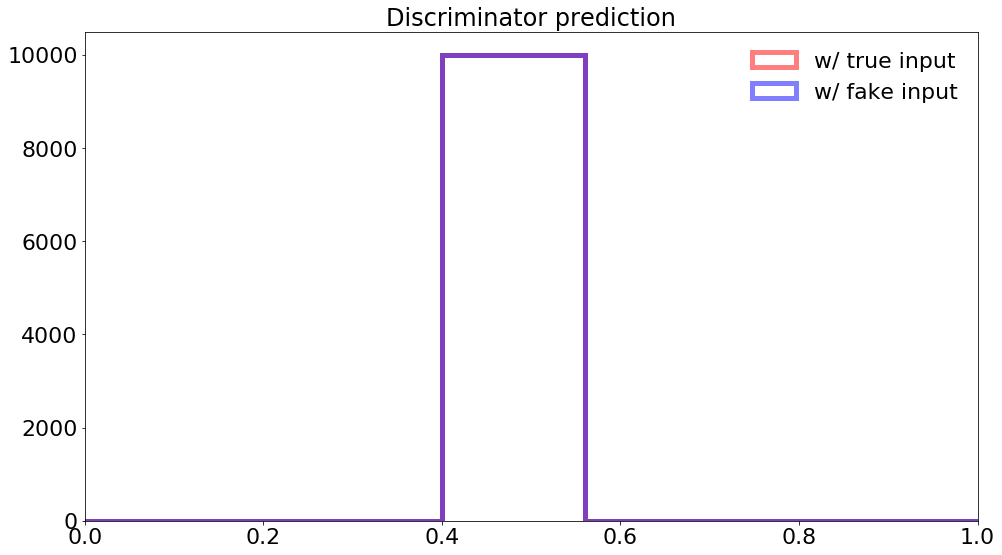

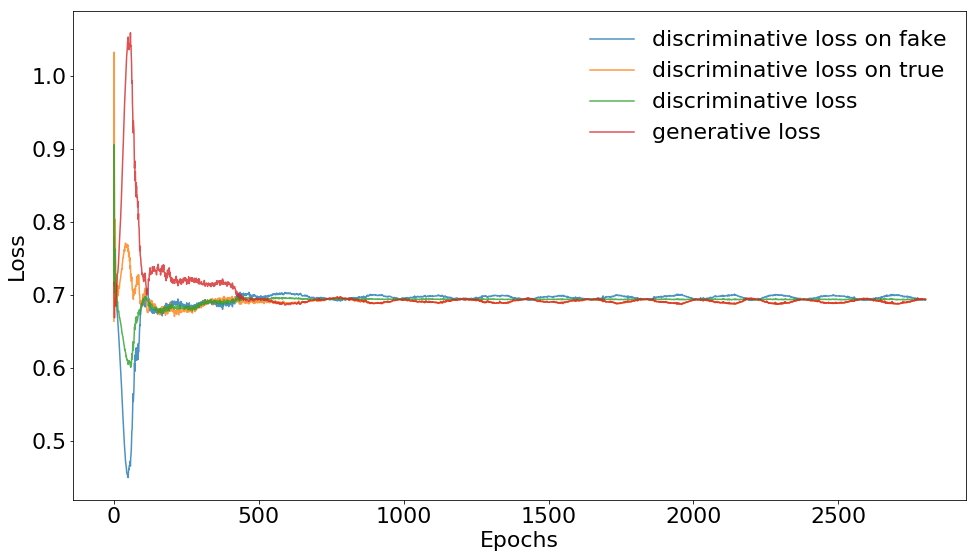

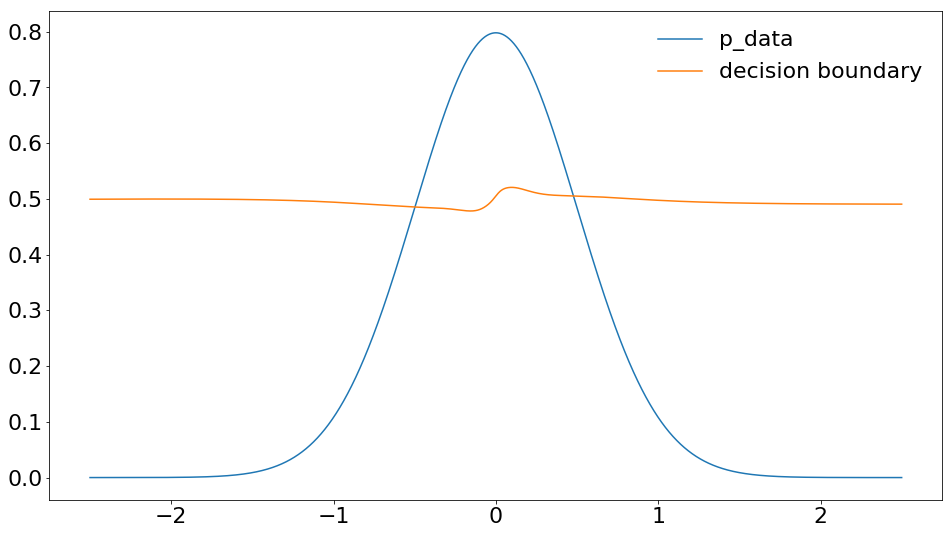

Epoch 851, Discriminator loss:0.693517446518, GAN loss:0.690627515316
For true: mean and s.d. =  -0.00418064799352 0.498982245597
For generator: mean and s.d. =  0.0301696 0.511871


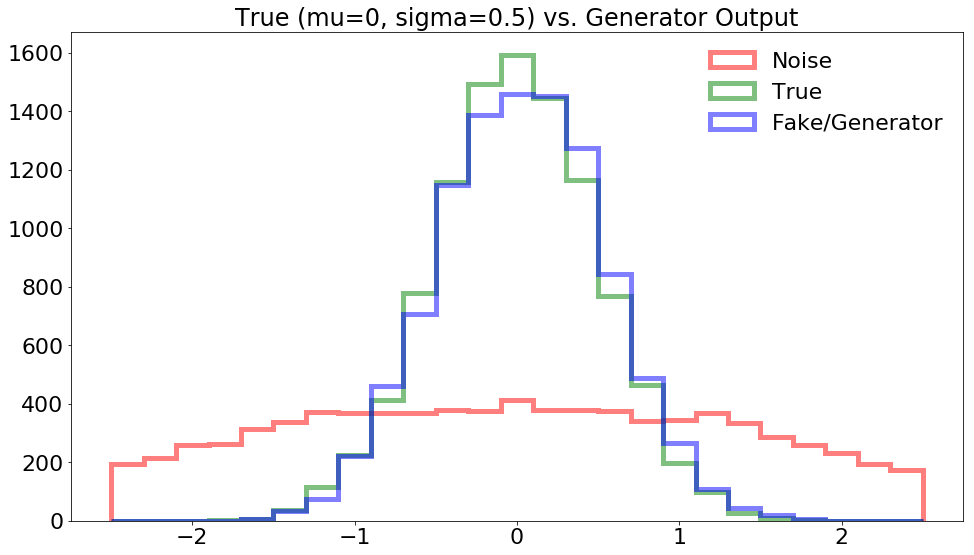

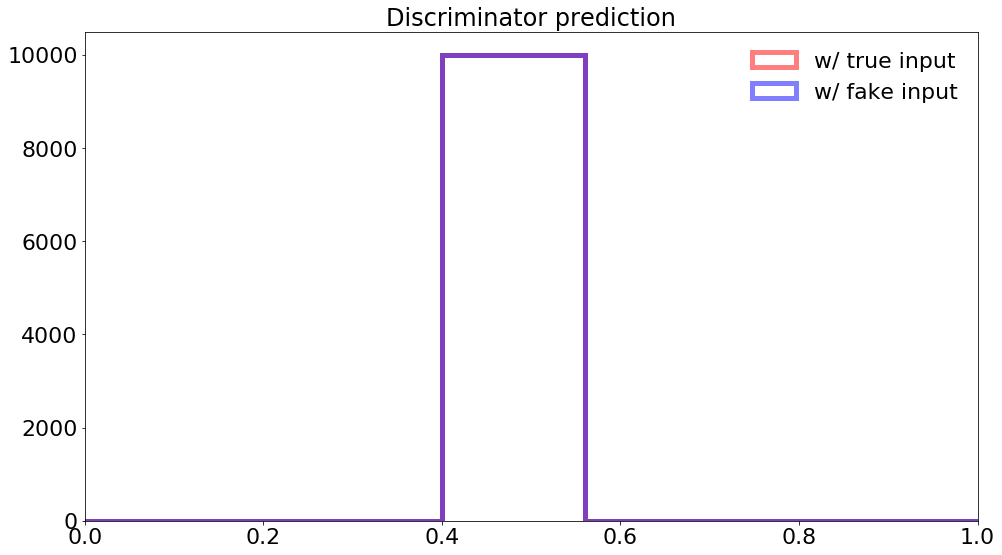

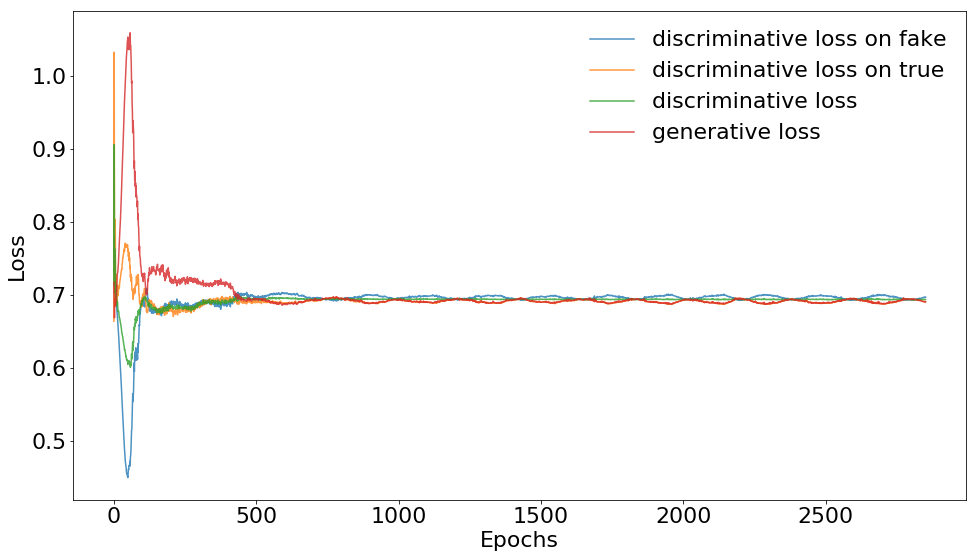

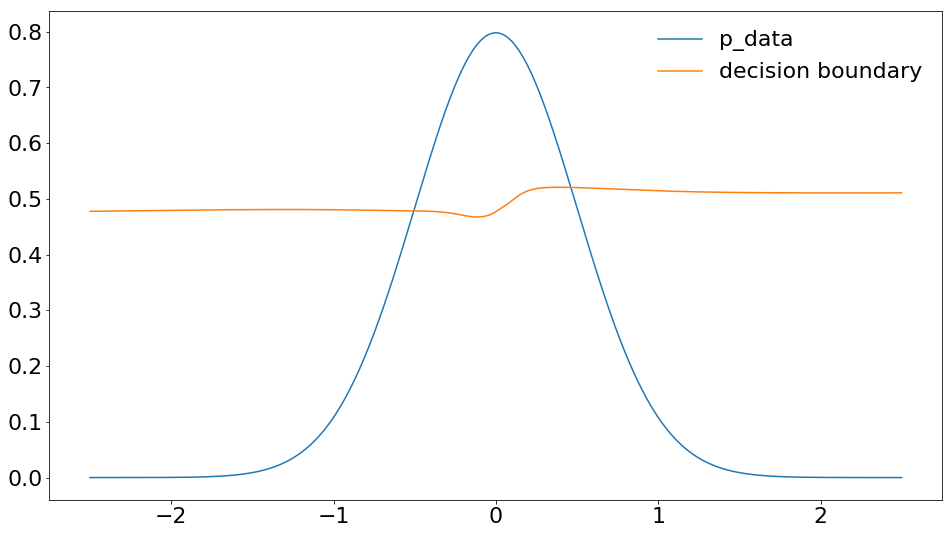

Epoch 901, Discriminator loss:0.69353723526, GAN loss:0.689258933067
For true: mean and s.d. =  -0.000361412204764 0.497394269892
For generator: mean and s.d. =  0.0106194 0.520925


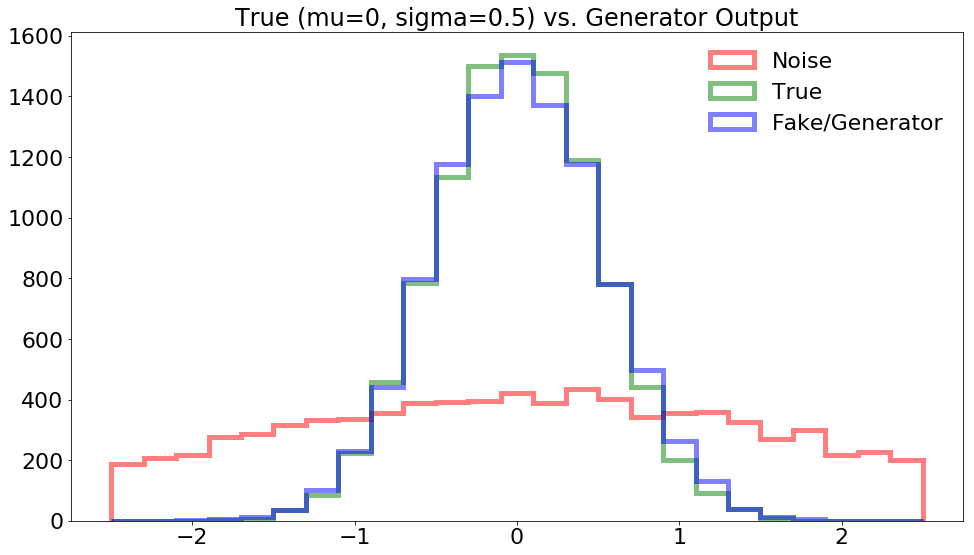

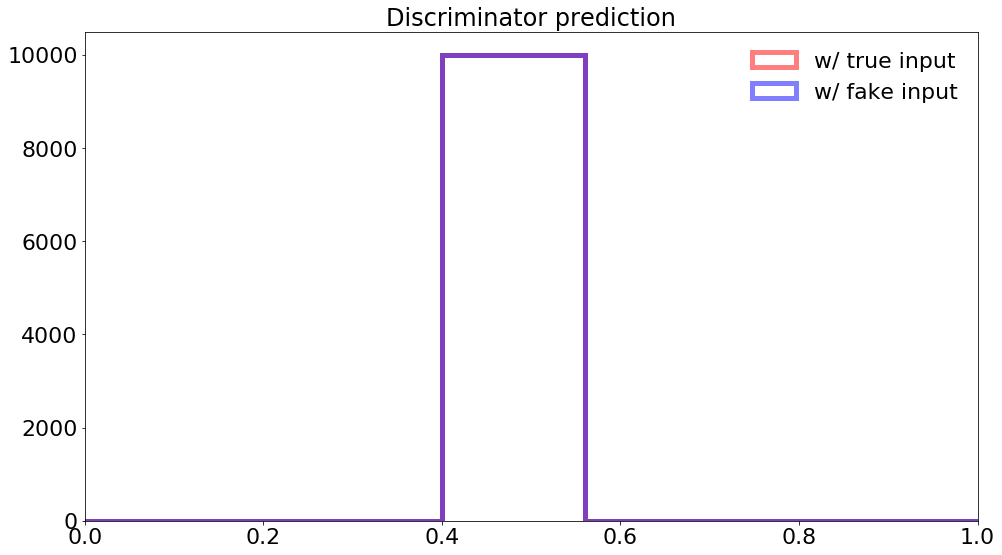

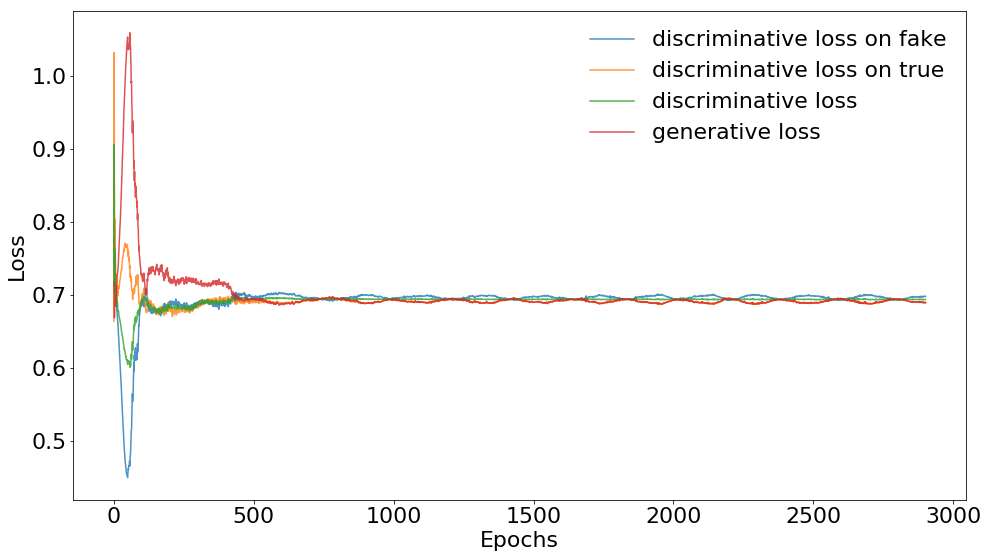

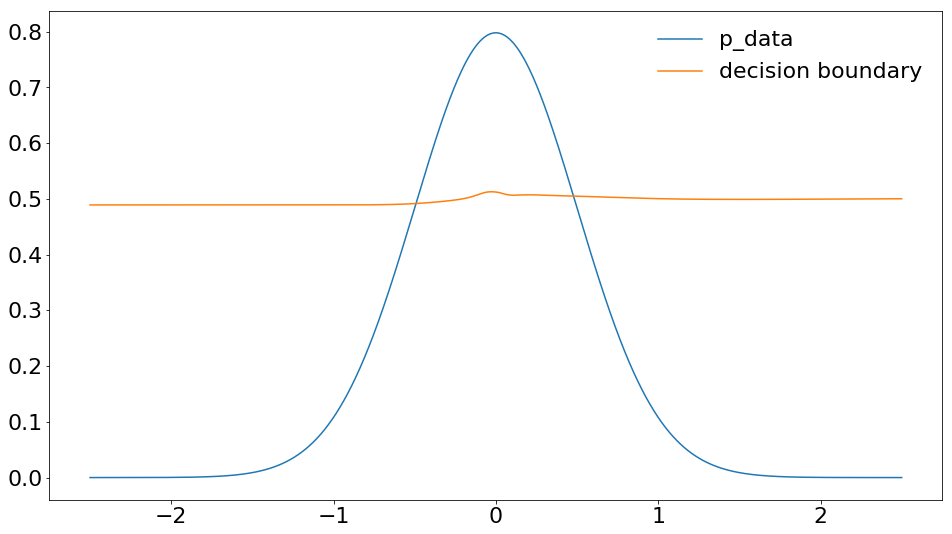

Epoch 951, Discriminator loss:0.69441395998, GAN loss:0.691117048264
For true: mean and s.d. =  0.0025086233217 0.498741077177
For generator: mean and s.d. =  0.00700588 0.479921


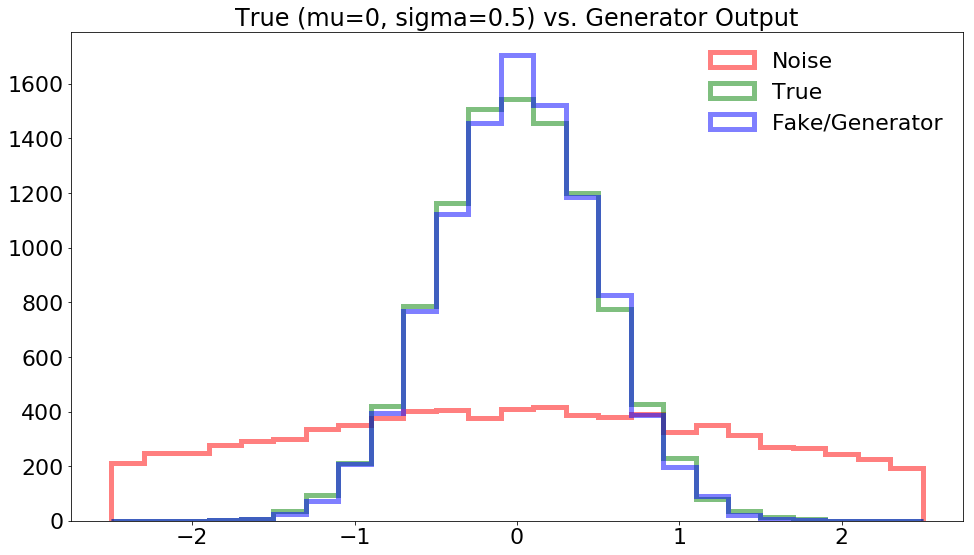

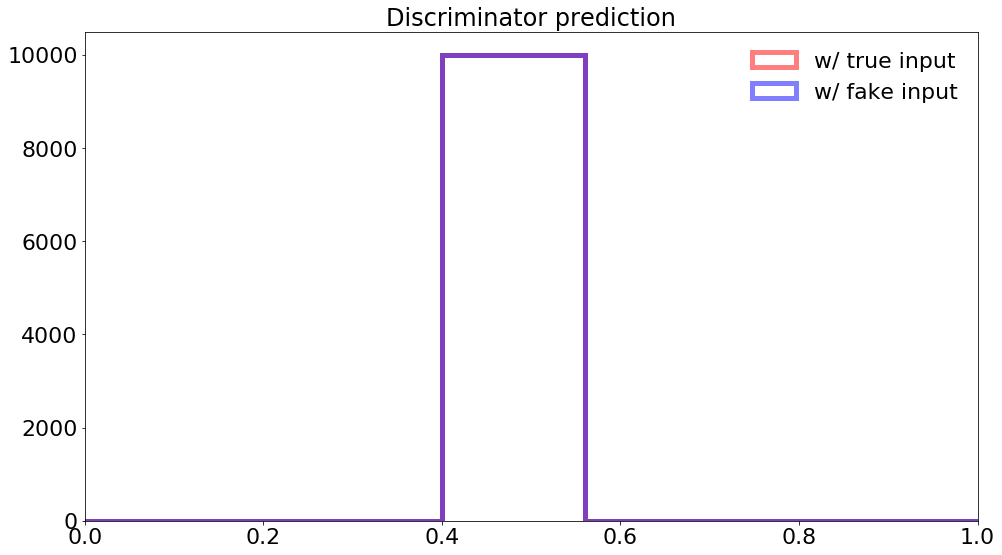

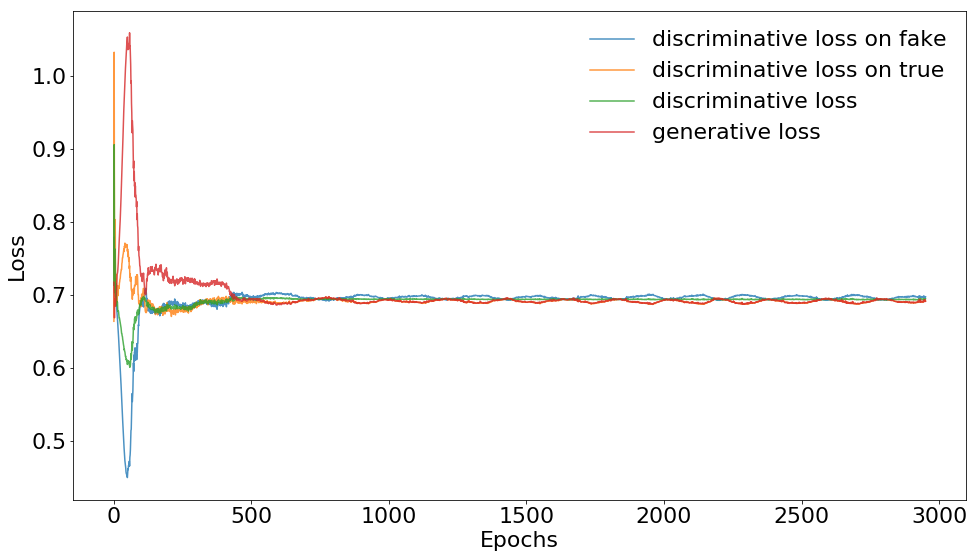

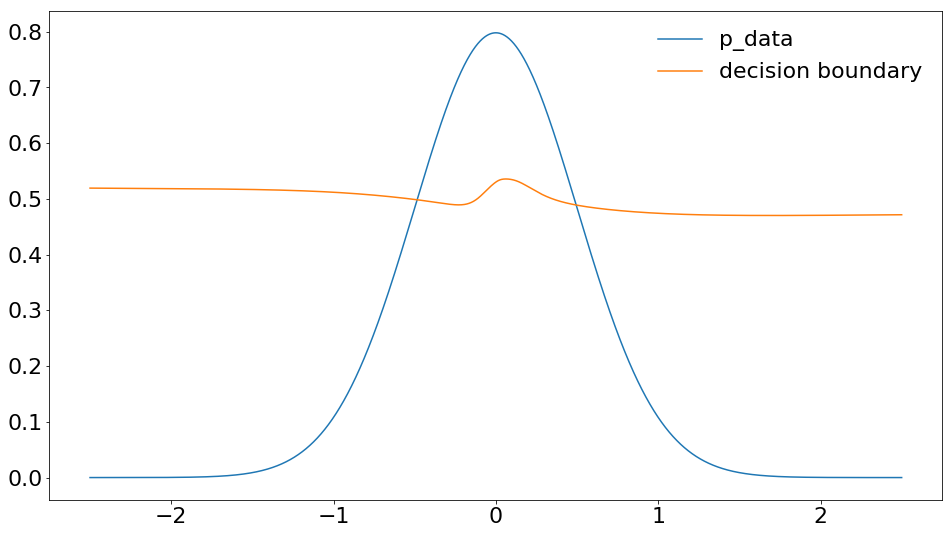

Epoch 1001, Discriminator loss:0.693304777145, GAN loss:0.694318592548
For true: mean and s.d. =  -0.00175653185347 0.497823954041
For generator: mean and s.d. =  0.00111727 0.481069


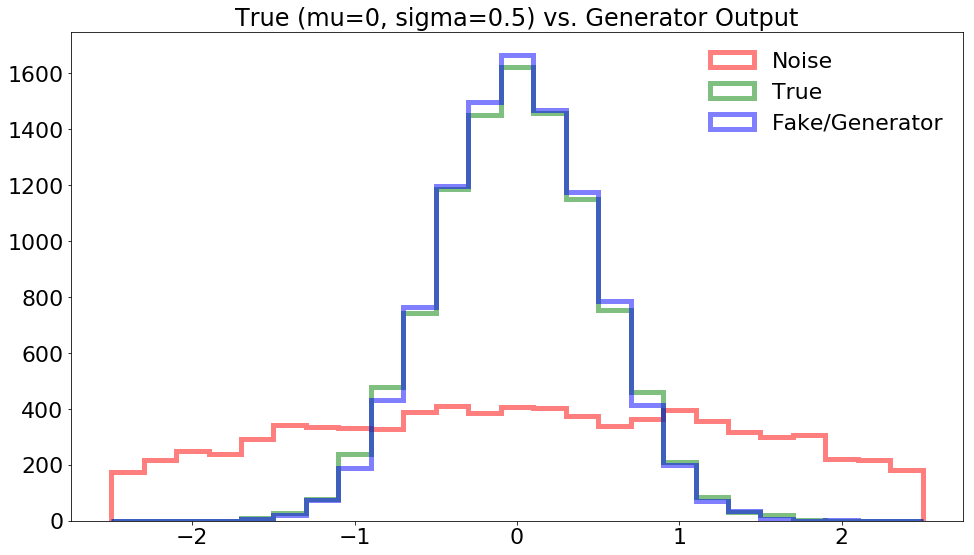

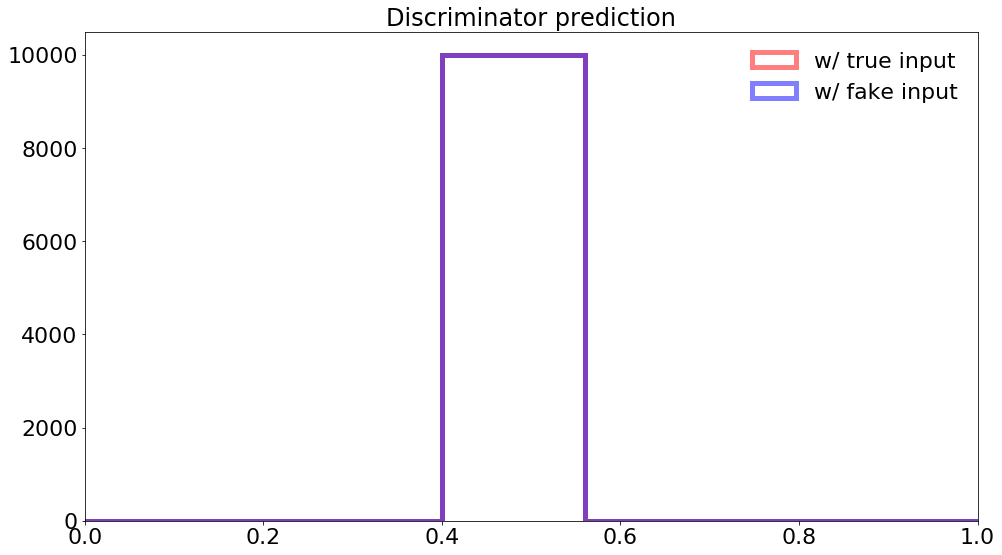

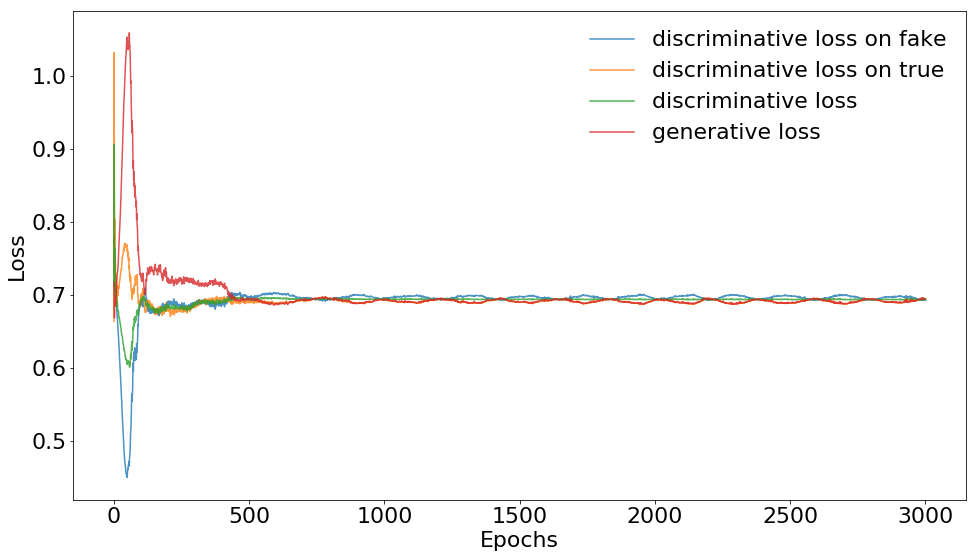

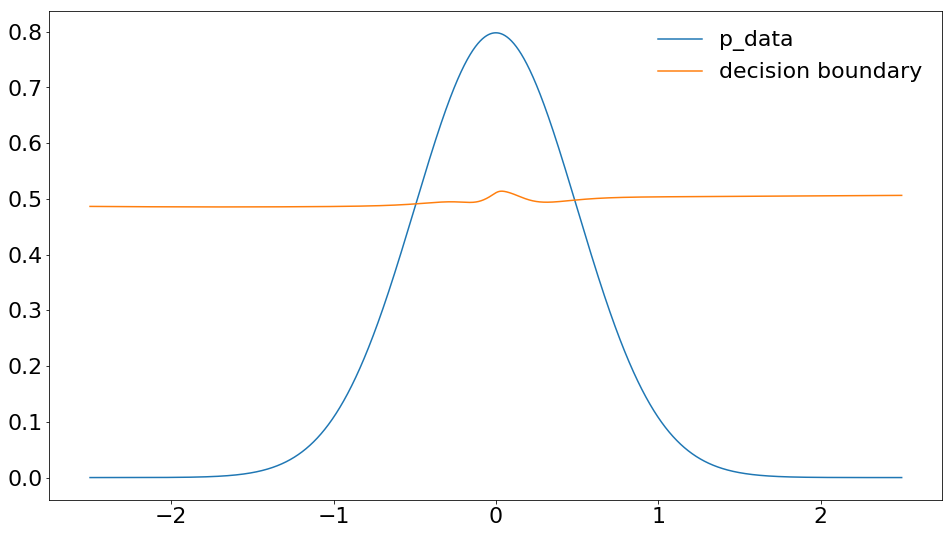

In [29]:
#training

batch_size = 3200
nb_epochs = 1001
#losses = {"d":[], "g":[]}

for i in range(0,nb_epochs):
    
    d_loss, g_loss = train(G,D,Model,i)
    #losses["d"].append(d_loss)
    #losses["g"].append(g_loss)  
    
    if i %50 == 0:
        print("Epoch {0}, Discriminator loss:{1}, GAN loss:{2}".format(i + 1, d_loss, g_loss))
        #overlay GAN output on the Gaussian we want
                
        true_disc = gaussian(10000,mu=0.,sigma=0.5)
        sd = np.std(true_disc)
        mean = np.mean(true_disc)
        print "For true: mean and s.d. = ", mean, sd
        latent = noise_g(10000,mu=0.,sigma=2.)
    
        G.trainable = False
        D.trainable = False
        fake_disc = G.predict(latent)
        
        sd = np.std(fake_disc)
        mean = np.mean(fake_disc)
        print "For generator: mean and s.d. = ", mean, sd
        
        plt.figure(figsize=(16,9))
        plt.title("True (mu=0, sigma=0.5) vs. Generator Output", fontsize=24)
        plt.hist(latent, color='r', histtype='step', linewidth=5, bins = 25, range = (-2.5,2.5), label = "Noise", alpha=0.5)
        plt.hist(true_disc, color='g', histtype='step', linewidth=5, bins = 25, range = (-2.5,2.5), label = "True", alpha=0.5)
        plt.hist(fake_disc, color='b', histtype='step', linewidth=5, bins = 25, range = (-2.5,2.5), label = 'Fake/Generator', alpha=0.5)
        plt.legend(loc='best', fontsize=22, fancybox=True, framealpha=0.)
        # plt.ylim(0,0.6)
        plt.rc('xtick', labelsize = 22)
        plt.rc('ytick', labelsize = 22)
        plt.show()     
        #print losses
        
        true_pred = D.predict(true_disc)
        fake_pred = D.predict(fake_disc)
            
        plt.figure(figsize=(16,9))
        plt.title("Discriminator prediction", fontsize=24)
        plt.hist(true_pred, color='r', histtype='step', linewidth=5, bins = 25, range = (-2.,2.), label = "w/ true input", alpha=0.5)
        plt.hist(fake_pred, color='b', histtype='step', linewidth=5, bins = 25, range = (-2.,2.), label = 'w/ fake input', alpha=0.5)
        plt.legend(loc='best', fontsize=22, fancybox=True, framealpha=0.)
        plt.xlim(0.,1.)
        plt.rc('xtick', labelsize = 22)
        plt.rc('ytick', labelsize = 22)
        plt.show()
        
        
        plot_loss(losses)
        plot_decision_boundary(D)
    #savemodel(model=Model, name="GaussiGAN_mb_gauslat")

0.00588836 0.481877


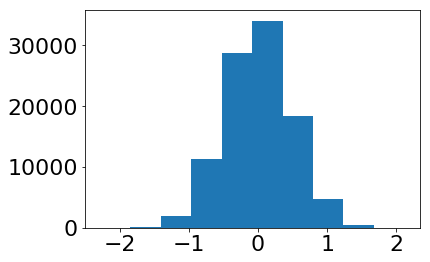

In [30]:
p = G.predict(noise_g(batch_size=100000, mu=0., sigma=2.))
plt.hist(p)
print p.mean(), p.std()

-2.26188464361 2.46019276819
For generator: mean and s.d =  0.00222655 1.20105


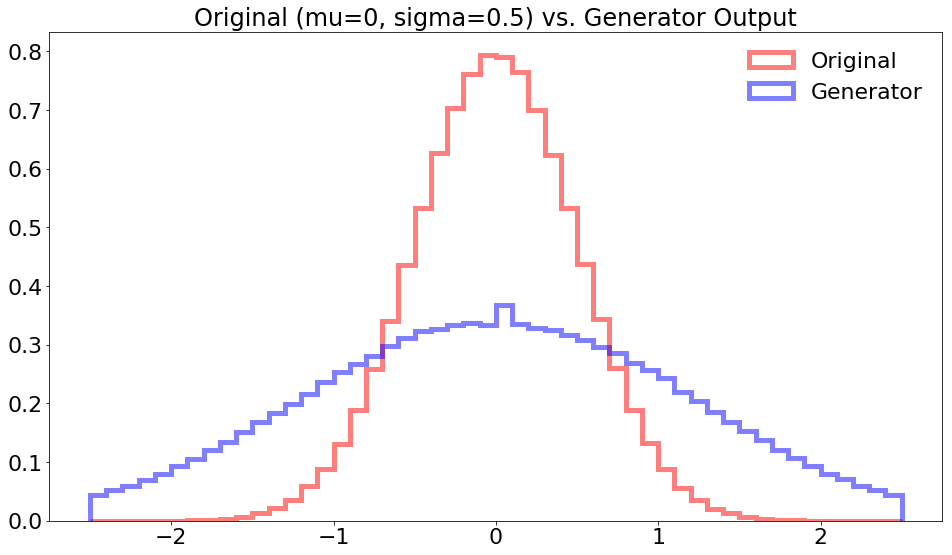

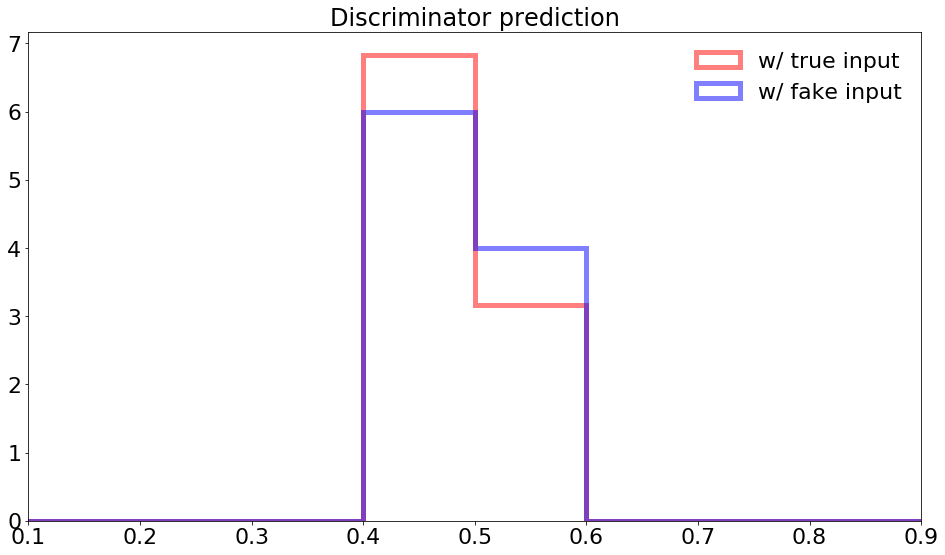

In [31]:
###################
batch_size = 1000000    
true_disc = gaussian(batch_size,mu=0.,sigma=0.5)
true_disc.sort()
print true_disc.min(), true_disc.max()
sd = np.std(true_disc)
mean = np.mean(true_disc)
latent = noise_g(batch_size,mu=0., sigma=5.0)
latent.sort()
G.trainable = False
D.trainable = False
fake_disc = G.predict(latent)
#print fake_disc
sd = np.std(fake_disc)
mean = np.mean(fake_disc)
print "For generator: mean and s.d = ", mean, sd
###################
        
plt.figure(figsize=(16,9))
plt.title("Original (mu=0, sigma=0.5) vs. Generator Output", fontsize=24)
plt.hist(true_disc, color='r', histtype='step', linewidth=5, bins = 50, range = (-2.5,2.5), label = "Original", alpha=0.5, normed=True)
plt.hist(fake_disc, color='b', histtype='step', linewidth=5, bins = 50, range = (-2.5,2.5), label = 'Generator', alpha=0.5, normed=True)
plt.legend(loc='best', fontsize=22, fancybox=True, framealpha=0.)
# plt.ylim(0,0.6)
plt.rc('xtick', labelsize = 22)
plt.rc('ytick', labelsize = 22)
# plt.savefig("GaussiGAN_mbd_unilat_gen_PDF.png")
plt.show()     
#print losses
        
true_pred = D.predict(true_disc)
fake_pred = D.predict(fake_disc)
            
plt.figure(figsize=(16,9))
plt.title("Discriminator prediction", fontsize=24)
plt.hist(true_pred, color='r', histtype='step', linewidth=5, bins = 10, range = (0.,1.), label = "w/ true input", alpha=0.5, normed=True)
plt.hist(fake_pred, color='b', histtype='step', linewidth=5, bins = 10, range = (0.,1.), label = 'w/ fake input', alpha=0.5, normed=True)
plt.legend(loc='best', fontsize=22, fancybox=True, framealpha=0.)
plt.xlim(0.1,0.9)
plt.rc('xtick', labelsize = 22)
plt.rc('ytick', labelsize = 22)
#plt.savefig("GaussiGAN_mbd_unilat_disc_pred.png")
plt.show()

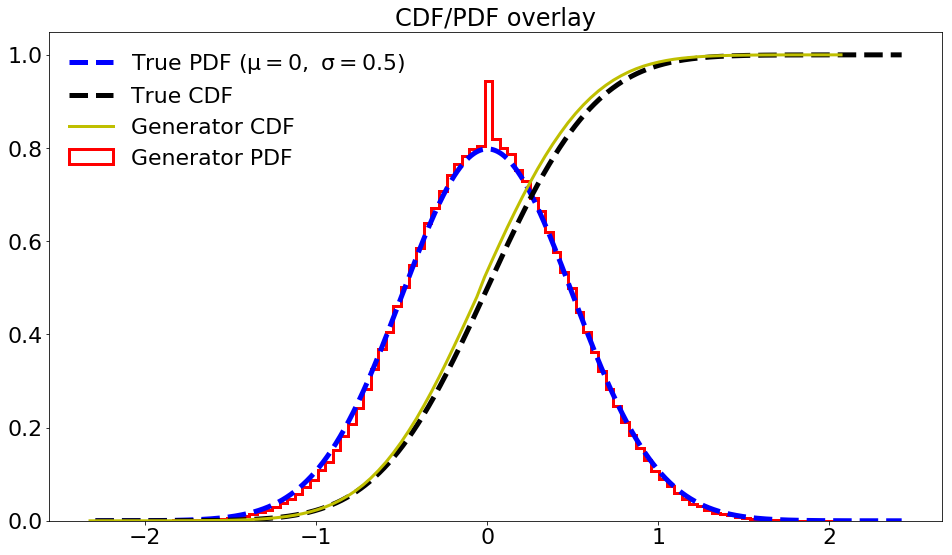

In [32]:
batch_size=1000000
import scipy.stats as stats        

true = gaussian(batch_size=batch_size, mu=0., sigma = 0.5)
true.sort()
tmean = np.mean(true)
tstd = np.std(true)
tpdf = stats.norm.pdf(true, tmean, tstd)
tcdf = stats.norm.cdf(true, tmean, tstd)
#x = np.linspace(true.min(), true.max(), 100000)

latent = noise_g(batch_size=batch_size, mu=0., sigma = 2.0)
latent.sort()
G_x = G.predict(latent)

H_G,X_G = np.histogram(G_x, bins = 100, normed = True )
dx = X_G[1] - X_G[0]
F_G = np.cumsum(H_G)*dx


plt.figure(figsize=(16,9))
plt.title("CDF/PDF overlay", fontsize=24)

plt.plot(true, tpdf, 
         color='b', linestyle='--', linewidth=5, label = r"$\mathrm{True\ PDF\ (\mu=0,\ \sigma=0.5)}$")

plt.plot(true, tcdf, 
         color = 'k', linestyle='--', linewidth=5, label = "True CDF")

plt.hist(G_x, histtype='step', bins =100, normed=True,
         color = 'r', linewidth=3, label ="Generator PDF")

plt.plot(X_G[:-1], F_G, 
         color = 'y', linewidth=3, label="Generator CDF")

plt.legend(loc='best', fontsize=22, fancybox=True, framealpha=0.)
plt.rc('xtick', labelsize = 22)
plt.rc('ytick', labelsize = 22)
#plt.savefig("GaussiGAN_1_mbd_g1_overlay.png")
plt.show()
